In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re,string,unicodedata
import keras
import tensorflow as tf
import sklearn.metrics as metrics
import re

from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,GRU, Dropout
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Read in 'kindle_reviews.csv' 982,619 reveiws

reviews = pd.read_csv('/Users/olivia/Desktop/Kindle Reviews/data/kindle_reviews.csv') 

reviews.head(5)

print(' There are {} reviews from Amazon reviews: Kindle Store Category. \n Number of review text is missing: {}\n Number of review rating is missing: {}'.format(len(reviews),len(reviews[reviews['reviewText'].isnull() == True]), len(reviews[reviews['overall'].isnull() == True])))

 There are 982619 reviews from Amazon reviews: Kindle Store Category. 
 Number of review text is missing: 22
 Number of review rating is missing: 0


In [3]:
# Drop Empty Reviews

reviews.dropna(subset=['reviewText'], inplace=True)

reviews = reviews.sample(frac=.05,random_state=999).reset_index()

reviews = reviews[['reviewText','summary','overall']]

reviews['reviewText'] = reviews['reviewText'] + reviews['summary']

reviews.drop('summary', axis=1, inplace=True)

pct=[]

for i in range(1,max(reviews['overall'])+1):
    count = len(reviews[reviews['overall']==i])
    rate = round((len(reviews[reviews['overall']==i])/len(reviews))*100,2)
    print('{} = {}: {}% of reviews, count = {} '.format('Rating',i,rate,count))
    pct.append(str(rate))

Rating = 1: 2.4% of reviews, count = 1180 
Rating = 2: 3.42% of reviews, count = 1682 
Rating = 3: 9.89% of reviews, count = 4859 
Rating = 4: 26.11% of reviews, count = 12826 
Rating = 5: 58.18% of reviews, count = 28583 


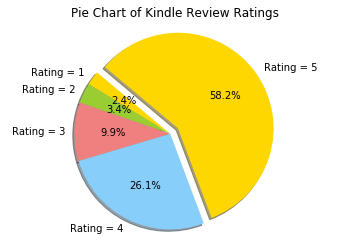

In [4]:
# Data to plot
labels = 'Rating = 1', 'Rating = 2', 'Rating = 3', 'Rating = 4', 'Rating = 5'
sizes = [pct[0],pct[1],pct[2],pct[3],pct[4]]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0, 0, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Pie Chart of Kindle Review Ratings')
plt.axis('equal')
plt.show()

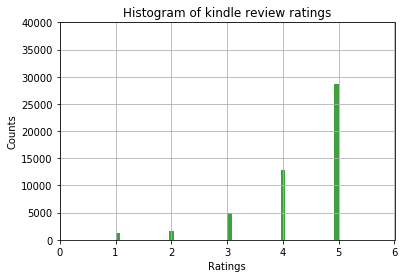

In [5]:
# the histogram of the ratings
plt.hist(reviews['overall'], 50, normed=0, facecolor='green', alpha=0.75)
plt.xlabel('Ratings')
plt.ylabel('Counts')
plt.title('Histogram of kindle review ratings')
plt.axis([0, 6,0,40000])
plt.grid(True)

In [6]:
# 3 classes - Negative, Neutral, Positive

import numpy as np

# convert ratings to sentiments
def rating_to_sentiment(reviews):
    reviews['sentiment'] = ""
    for i in range(len(reviews)):
        if (reviews['overall'][i] == 1 or reviews['overall'][i] == 2):
            reviews['sentiment'][i] = 'Negative'
        elif (reviews['overall'][i] == 3):
            reviews['sentiment'][i] = 'Neutral'
        else:
            reviews['sentiment'][i] = 'Positive'
    return reviews
            
# under-sampling 
def under_sampling(reviews):
    negative = len(reviews[reviews['sentiment'] == 'Negative'])
    under_sample_indices = reviews[reviews.sentiment == 'Negative'].index
    random1 = np.random.choice(reviews[reviews.sentiment == 'Neutral'].index, negative, replace=False)
    random2 = np.random.choice(reviews[reviews.sentiment == 'Positive'].index, negative, replace=False)
    under_sample_indices = np.concatenate([under_sample_indices, random1, random2])
    reviews_under_sample = reviews.loc[under_sample_indices].reset_index(drop=True)
    reviews_under_sample.drop('overall',axis=1, inplace=True)
    return reviews_under_sample

def balanced_classification(reviews):
    reviews = rating_to_sentiment(reviews)
    reviews_under_sample = under_sampling(reviews)
    return reviews_under_sample

reviews_under_sample = balanced_classification(reviews)

reviews_under_sample.replace({'Negative':0,'Neutral':1,'Positive':2},inplace=True)

reviews_under_sample = reviews_under_sample.sample(frac=1, random_state = 233).reset_index(drop=True)

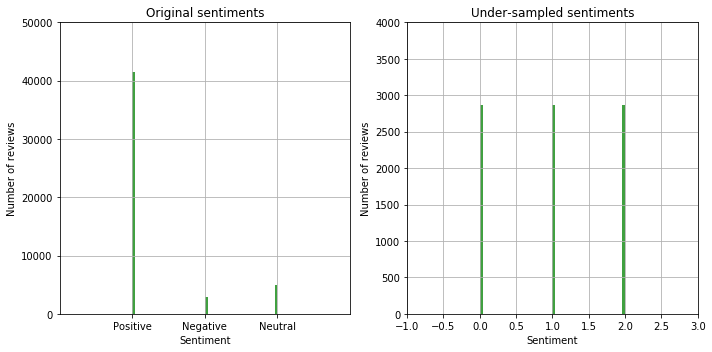

In [7]:
def hist(data,title,ymax):
    # the histogram of the ratings
    plt.hist(data['sentiment'], 50, normed=0, facecolor='green', alpha=0.75)
    plt.xlabel('Sentiment')
    plt.ylabel('Number of reviews')
    plt.title('{} sentiments'.format(title))

    plt.xlim(-1,2)
    plt.ylim(0,ymax)

    plt.grid(True)

plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
hist(reviews,'Original',50000) #1,000,000
plt.xlim(-1, 3)
plt.subplot(1,2,2) 
hist(reviews_under_sample,'Under-sampled',4000) #80,000
plt.xlim(-1, 3)
plt.tight_layout() 
plt.show() 

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop_words.update(punctuation)
stop_words.update('’')
stop_words.update('“')
stop_words.update('”')

contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

def contractions_re(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    return text 

#Removing the stopwords from text
def remove_stopwords(s):
    words = str(s).lower()
    words = word_tokenize(words)
    return [w for w in words if not w in stop_words]

#lemmatization
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_tokens(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(sentence)  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(WordNetLemmatizer().lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

# Removing URL's
def remove_URL(text):
    return re.sub(r'http\S+', '', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        u"\U0001F913"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_stopwords(s):
    words = str(s).lower()
    words = word_tokenize(words)
    return [w for w in words if not w in stop_words]

# Remove the noisy text
def denoise_text(text):
    text = [contractions_re(x) for x in text]
    text = [remove_stopwords(x) for x in text]
    text = [lemmatize_tokens(x) for x in text]
    text = [remove_URL(x) for x in text] 
    text = [remove_emoji(x) for x in text]
    return text

corpus = denoise_text(reviews_under_sample.reviewText)

corpus_sentiment = pd.concat([pd.DataFrame(corpus),pd.DataFrame(reviews_under_sample['sentiment'])],axis=1)

corpus_sentiment.columns = ['corpus','sentiment']

[nltk_data] Downloading package punkt to /Users/olivia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/olivia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/olivia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olivia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


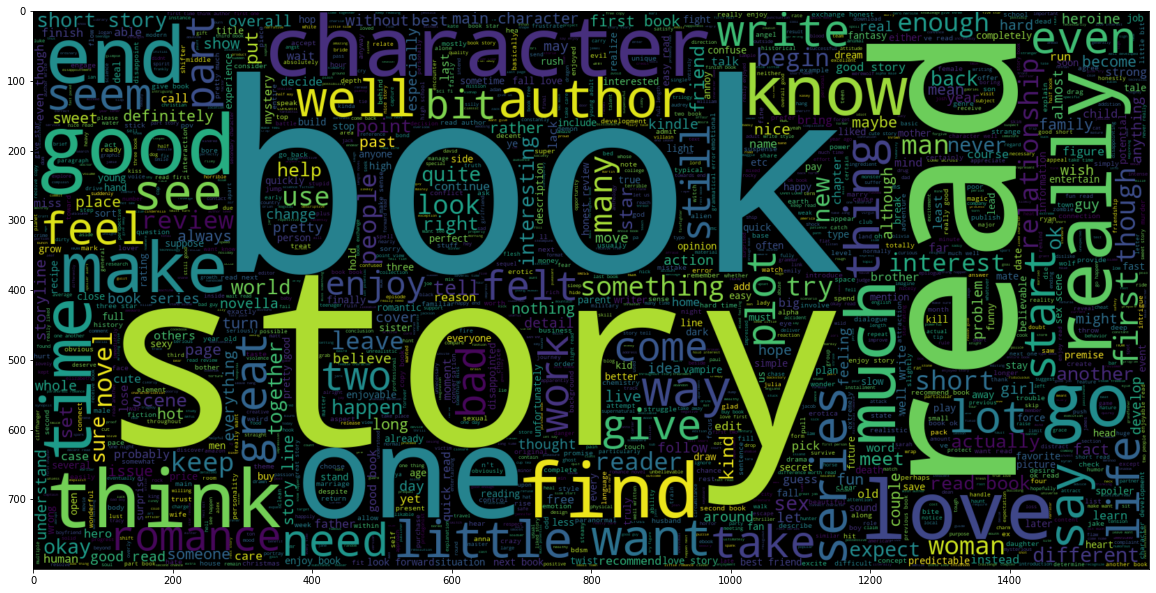

In [9]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(corpus_sentiment[corpus_sentiment.sentiment == 1].corpus))
plt.imshow(wc , interpolation = 'bilinear')

In [10]:
def max_length_review(corpus):
    corpus_token = [word_tokenize(x) for x in corpus]
    maxLen = len(max(corpus_token,key=len))
    print (' The max length of kindle reviews is {}'.format(maxLen))

    max_index = corpus_token.index(max(corpus_token,key=len))
    text_body = reviews_under_sample.reviewText[max_index]
    rating = reviews_under_sample.sentiment[max_index]
    print(' Index : {} \n Sentiment : {} \n Text body: \n {}'.format(max_index,rating, text_body))

max_length_review(corpus)

 The max length of kindle reviews is 1220
 Index : 2374 
 Sentiment : 1 
 Text body: 
 For the links to the Chinese Horoscope sites, visit  [...]Rating: 3.75 stars out of 5With a British mother and a hard as the ground Texas father, Preston Hawks finds himself at 10 years old scrambling to find some middle ground between his parents and a place to fit in, something that is not happening for him in Texas.  Then Pres meets fifteen-year-old Konrad Schnell at the San Antonio Polo Club.  Instantly smitten with both Konrad and the sport of polo,  Pres finds himself spending every moment possible in the company of the older boy, learning how to play and idolizing Konrad.  As the years progress, Pres' hero worship turns into friendship and then into love.  But being gay during the 70&#8242;s is perilous to their health, especially so in Texas.  So the boys love for each other stays hidden, much to Pres' consternation until they part when Pres is sent off to boarding school in England.With Konr

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(corpus, pd.DataFrame(reviews_under_sample['sentiment']).astype('int'), test_size=0.1, random_state=3)

In [12]:
def convert_to_one_hot(Y, C):
    targets = np.array(Y).reshape(-1)
    one_hot_targets = np.eye(C)[targets]
    return one_hot_targets

Y_train_oh = convert_to_one_hot(Y_train,3)
Y_test_oh = convert_to_one_hot(Y_test,3)

In [13]:
# Bag of words - 'CountVectorizer'

from sklearn.feature_extraction.text import CountVectorizer

def BagofWords(X_train, X_test):
    vectorizer = CountVectorizer(min_df=10,ngram_range=(1, 2),stop_words=stop_words,max_features=2000)
    vectorizer_fit = vectorizer.fit(X_train)
    X_train_BoW = vectorizer_fit.transform(X_train)
    X_test_BoW = vectorizer_fit.transform(X_test)
    return X_train_BoW, X_test_BoW
X_train_BoW, X_test_BoW = BagofWords(X_train, X_test)

# One-Hot - 'Binarizer'

from sklearn.preprocessing import Binarizer

def onehot(X_train_BoW, X_test_BoW):
    onehot = Binarizer()
    X_train_oh = onehot.fit_transform(X_train_BoW)
    X_test_oh = onehot.fit_transform(X_test_BoW)
    return X_train_oh, X_test_oh
X_train_oh, X_test_oh = onehot(X_train_BoW, X_test_BoW)

#TF-IDF - 'TfidfVectorizer'

from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(X_train, X_test):
    tfidf = TfidfVectorizer(min_df=5,ngram_range=(1, 2),stop_words=stop_words,max_features=2000)
    tf_fit = tfidf.fit(X_train)
    X_train_tfidf = tf_fit.transform(X_train)
    X_test_tfidf = tf_fit.transform(X_test)
    return X_train_tfidf, X_test_tfidf

X_train_tfidf, X_test_tfidf = tfidf(X_train, X_test)

In [14]:
# One-Hot --> SVM (Baseline) -- > Test Accuracy: 62.51%

from sklearn import svm
from sklearn.svm import SVC 

svm = SVC(C=1, kernel='linear')
svm.fit(X_train_oh, Y_train)

def performance(model,X_test,Y_test):
    yhat = model.predict(X_test)
    print('Classification report : \n',classification_report(Y_test, yhat))
    print('Confusion matrix : \n',confusion_matrix(Y_test,yhat))
    acc_pct = np.around(((confusion_matrix(Y_test,yhat)[0][0]+confusion_matrix(Y_test,yhat)[1][1]+confusion_matrix(Y_test,yhat)[2][2])/confusion_matrix(Y_test,yhat).sum())*100 , decimals=2)
    return print('Test accuracy : {}%'.format(acc_pct))

performance(svm, X_test_oh , Y_test) 

Classification report : 
               precision    recall  f1-score   support

           0       0.61      0.68      0.65       280
           1       0.52      0.53      0.52       277
           2       0.75      0.67      0.70       302

    accuracy                           0.63       859
   macro avg       0.63      0.62      0.62       859
weighted avg       0.63      0.63      0.63       859

Confusion matrix : 
 [[190  74  16]
 [ 79 146  52]
 [ 40  61 201]]
Test accuracy : 62.51%


In [15]:
# One-Hot --> MultinomialNB -- > Accuracy: 70.9%

from sklearn.naive_bayes import MultinomialNB

def MultinomialNB_classifier(X, Y_train):
    np.random.seed(999)
    nb_classifier = MultinomialNB()
    params_NB = {'alpha': np.logspace(1,-9, num=100)}
    mt_NB = GridSearchCV(estimator=nb_classifier, 
                     param_grid=params_NB, 
                     cv=5,
                     verbose=2, 
                     refit = True,
                     scoring='accuracy')
    mt_NB.fit(X, Y_train)
    return mt_NB
def Smoothing_loss_plot(mt_NB):
    results_NB = pd.DataFrame(mt_NB.cv_results_['params'])
    results_NB['test_score'] = mt_NB.cv_results_['mean_test_score']
    print('Best Var.Smoothing : {}'.format(mt_NB.best_params_))
    plt.plot(results_NB['alpha'], results_NB['test_score'], marker = '.')    
    plt.xlabel('Var. Smoothing')
    plt.ylabel("Mean CV Score")
    plt.title("MultinomialNB Performance Comparison")
    plt.show()
    
Oh_NB = MultinomialNB_classifier(X_train_oh, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=7.924828983539173 .........................................
[CV] .......................... alpha=7.924828983539173, total=   0.0s
[CV] alpha=7.924828983539173 .........................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................... alpha=4.977023564332112, total=   0.0s
[CV] alpha=4.977023564332112 .........................................
[CV] .......................... alpha=4.977023564332112, total=   0.0s
[CV] alpha=3.944206059437656 .........................................
[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.944206059437656 .........................................
[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.944206059437656 .........................................
[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.944206059437656 .........................................
[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.944206059437656 .........................................
[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.1257158496882362 ........................................
[CV] .

[CV] ........................ alpha=0.19179102616724888, total=   0.0s
[CV] alpha=0.19179102616724888 .......................................
[CV] ........................ alpha=0.19179102616724888, total=   0.0s
[CV] alpha=0.19179102616724888 .......................................
[CV] ........................ alpha=0.19179102616724888, total=   0.0s
[CV] alpha=0.1519911082952934 ........................................
[CV] ......................... alpha=0.1519911082952934, total=   0.0s
[CV] alpha=0.1519911082952934 ........................................
[CV] ......................... alpha=0.1519911082952934, total=   0.0s
[CV] alpha=0.1519911082952934 ........................................
[CV] ......................... alpha=0.1519911082952934, total=   0.0s
[CV] alpha=0.1519911082952934 ........................................
[CV] ......................... alpha=0.1519911082952934, total=   0.0s
[CV] alpha=0.1519911082952934 ........................................
[CV] .

[CV] ....................... alpha=0.011768119524349991, total=   0.0s
[CV] alpha=0.011768119524349991 ......................................
[CV] ....................... alpha=0.011768119524349991, total=   0.0s
[CV] alpha=0.011768119524349991 ......................................
[CV] ....................... alpha=0.011768119524349991, total=   0.0s
[CV] alpha=0.011768119524349991 ......................................
[CV] ....................... alpha=0.011768119524349991, total=   0.0s
[CV] alpha=0.0093260334688322 ........................................
[CV] ......................... alpha=0.0093260334688322, total=   0.0s
[CV] alpha=0.0093260334688322 ........................................
[CV] ......................... alpha=0.0093260334688322, total=   0.0s
[CV] alpha=0.0093260334688322 ........................................
[CV] ......................... alpha=0.0093260334688322, total=   0.0s
[CV] alpha=0.0093260334688322 ........................................
[CV] .

[CV] ...................... alpha=0.0005722367659350221, total=   0.0s
[CV] alpha=0.00045348785081285824 ....................................
[CV] ..................... alpha=0.00045348785081285824, total=   0.0s
[CV] alpha=0.00045348785081285824 ....................................
[CV] ..................... alpha=0.00045348785081285824, total=   0.0s
[CV] alpha=0.00045348785081285824 ....................................
[CV] ..................... alpha=0.00045348785081285824, total=   0.0s
[CV] alpha=0.00045348785081285824 ....................................
[CV] ..................... alpha=0.00045348785081285824, total=   0.0s
[CV] alpha=0.00045348785081285824 ....................................
[CV] ..................... alpha=0.00045348785081285824, total=   0.0s
[CV] alpha=0.00035938136638046257 ....................................
[CV] ..................... alpha=0.00035938136638046257, total=   0.0s
[CV] alpha=0.00035938136638046257 ....................................
[CV] .

[CV] ..................... alpha=2.2051307399030455e-05, total=   0.0s
[CV] alpha=2.2051307399030455e-05 ....................................
[CV] ..................... alpha=2.2051307399030455e-05, total=   0.0s
[CV] alpha=2.2051307399030455e-05 ....................................
[CV] ..................... alpha=2.2051307399030455e-05, total=   0.0s
[CV] alpha=2.2051307399030455e-05 ....................................
[CV] ..................... alpha=2.2051307399030455e-05, total=   0.0s
[CV] alpha=2.2051307399030455e-05 ....................................
[CV] ..................... alpha=2.2051307399030455e-05, total=   0.0s
[CV] alpha=1.747528400007683e-05 .....................................
[CV] ...................... alpha=1.747528400007683e-05, total=   0.0s
[CV] alpha=1.747528400007683e-05 .....................................
[CV] ...................... alpha=1.747528400007683e-05, total=   0.0s
[CV] alpha=1.747528400007683e-05 .....................................
[CV] .

[CV] ..................... alpha=1.0722672220103232e-06, total=   0.0s
[CV] alpha=1.0722672220103232e-06 ....................................
[CV] ..................... alpha=1.0722672220103232e-06, total=   0.0s
[CV] alpha=1.0722672220103232e-06 ....................................
[CV] ..................... alpha=1.0722672220103232e-06, total=   0.0s
[CV] alpha=1.0722672220103232e-06 ....................................
[CV] ..................... alpha=1.0722672220103232e-06, total=   0.0s
[CV] alpha=8.497534359086439e-07 .....................................
[CV] ...................... alpha=8.497534359086439e-07, total=   0.0s
[CV] alpha=8.497534359086439e-07 .....................................
[CV] ...................... alpha=8.497534359086439e-07, total=   0.0s
[CV] alpha=8.497534359086439e-07 .....................................
[CV] ...................... alpha=8.497534359086439e-07, total=   0.0s
[CV] alpha=8.497534359086439e-07 .....................................
[CV] .

[CV] ...................... alpha=5.214008287999695e-08, total=   0.0s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] ...................... alpha=4.132012400115334e-08, total=   0.0s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] ...................... alpha=4.132012400115334e-08, total=   0.0s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] ...................... alpha=4.132012400115334e-08, total=   0.0s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] ...................... alpha=4.132012400115334e-08, total=   0.0s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] ...................... alpha=4.132012400115334e-08, total=   0.0s
[CV] alpha=3.274549162877732e-08 .....................................
[CV] ...................... alpha=3.274549162877732e-08, total=   0.0s
[CV] alpha=3.274549162877732e-08 .....................................
[CV] .

[CV] ..................... alpha=3.1992671377973846e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.009233002565046e-09 .....................................
[CV] ...................... alpha=2.009233002565046e-09, total=   0.0s
[CV] alpha=2.009233002565046e-09 .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.9s finished


Best Var.Smoothing : {'alpha': 3.944206059437656}


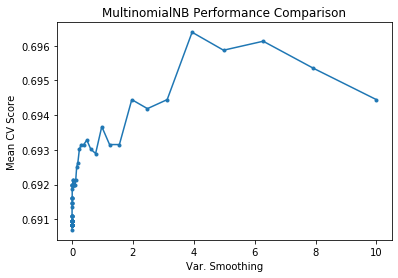

In [16]:
Smoothing_loss_plot(Oh_NB)

In [17]:
performance(Oh_NB, X_test_oh, Y_test) 

Classification report : 
               precision    recall  f1-score   support

           0       0.71      0.72      0.72       280
           1       0.59      0.61      0.60       277
           2       0.82      0.78      0.80       302

    accuracy                           0.71       859
   macro avg       0.71      0.71      0.71       859
weighted avg       0.71      0.71      0.71       859

Confusion matrix : 
 [[202  69   9]
 [ 63 170  44]
 [ 18  47 237]]
Test accuracy : 70.9%


In [18]:
# Bag of Words --> MultinomialNB -- > Accuracy: 70.08%

BoW_NB = MultinomialNB_classifier(X_train_BoW, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=7.924828983539173 .........................................
[CV] .......................... alpha=7.924828983539173, total=   0.0s
[CV] alpha=7.924828983539173 .........................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................... alpha=4.977023564332112, total=   0.0s
[CV] alpha=4.977023564332112 .........................................
[CV] .......................... alpha=4.977023564332112, total=   0.0s
[CV] alpha=3.944206059437656 .........................................
[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.944206059437656 .........................................
[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.944206059437656 .........................................
[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.944206059437656 .........................................
[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.944206059437656 .........................................
[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.1257158496882362 ........................................
[CV] .

[CV] ........................ alpha=0.30538555088334157, total=   0.0s
[CV] alpha=0.24201282647943823 .......................................
[CV] ........................ alpha=0.24201282647943823, total=   0.0s
[CV] alpha=0.24201282647943823 .......................................
[CV] ........................ alpha=0.24201282647943823, total=   0.1s
[CV] alpha=0.24201282647943823 .......................................
[CV] ........................ alpha=0.24201282647943823, total=   0.0s
[CV] alpha=0.24201282647943823 .......................................
[CV] ........................ alpha=0.24201282647943823, total=   0.0s
[CV] alpha=0.24201282647943823 .......................................
[CV] ........................ alpha=0.24201282647943823, total=   0.0s
[CV] alpha=0.19179102616724888 .......................................
[CV] ........................ alpha=0.19179102616724888, total=   0.0s
[CV] alpha=0.19179102616724888 .......................................
[CV] .

[CV] ....................... alpha=0.011768119524349991, total=   0.0s
[CV] alpha=0.011768119524349991 ......................................
[CV] ....................... alpha=0.011768119524349991, total=   0.0s
[CV] alpha=0.011768119524349991 ......................................
[CV] ....................... alpha=0.011768119524349991, total=   0.0s
[CV] alpha=0.0093260334688322 ........................................
[CV] ......................... alpha=0.0093260334688322, total=   0.0s
[CV] alpha=0.0093260334688322 ........................................
[CV] ......................... alpha=0.0093260334688322, total=   0.0s
[CV] alpha=0.0093260334688322 ........................................
[CV] ......................... alpha=0.0093260334688322, total=   0.0s
[CV] alpha=0.0093260334688322 ........................................
[CV] ......................... alpha=0.0093260334688322, total=   0.0s
[CV] alpha=0.0093260334688322 ........................................
[CV] .

[CV] ...................... alpha=0.0005722367659350221, total=   0.0s
[CV] alpha=0.0005722367659350221 .....................................
[CV] ...................... alpha=0.0005722367659350221, total=   0.0s
[CV] alpha=0.00045348785081285824 ....................................
[CV] ..................... alpha=0.00045348785081285824, total=   0.0s
[CV] alpha=0.00045348785081285824 ....................................
[CV] ..................... alpha=0.00045348785081285824, total=   0.0s
[CV] alpha=0.00045348785081285824 ....................................
[CV] ..................... alpha=0.00045348785081285824, total=   0.0s
[CV] alpha=0.00045348785081285824 ....................................
[CV] ..................... alpha=0.00045348785081285824, total=   0.0s
[CV] alpha=0.00045348785081285824 ....................................
[CV] ..................... alpha=0.00045348785081285824, total=   0.0s
[CV] alpha=0.00035938136638046257 ....................................
[CV] .

[CV] ...................... alpha=2.782559402207126e-05, total=   0.0s
[CV] alpha=2.2051307399030455e-05 ....................................
[CV] ..................... alpha=2.2051307399030455e-05, total=   0.0s
[CV] alpha=2.2051307399030455e-05 ....................................
[CV] ..................... alpha=2.2051307399030455e-05, total=   0.0s
[CV] alpha=2.2051307399030455e-05 ....................................
[CV] ..................... alpha=2.2051307399030455e-05, total=   0.0s
[CV] alpha=2.2051307399030455e-05 ....................................
[CV] ..................... alpha=2.2051307399030455e-05, total=   0.0s
[CV] alpha=2.2051307399030455e-05 ....................................
[CV] ..................... alpha=2.2051307399030455e-05, total=   0.0s
[CV] alpha=1.747528400007683e-05 .....................................
[CV] ...................... alpha=1.747528400007683e-05, total=   0.0s
[CV] alpha=1.747528400007683e-05 .....................................
[CV] .

[CV] ..................... alpha=1.3530477745798075e-06, total=   0.0s
[CV] alpha=1.3530477745798075e-06 ....................................
[CV] ..................... alpha=1.3530477745798075e-06, total=   0.0s
[CV] alpha=1.0722672220103232e-06 ....................................
[CV] ..................... alpha=1.0722672220103232e-06, total=   0.0s
[CV] alpha=1.0722672220103232e-06 ....................................
[CV] ..................... alpha=1.0722672220103232e-06, total=   0.0s
[CV] alpha=1.0722672220103232e-06 ....................................
[CV] ..................... alpha=1.0722672220103232e-06, total=   0.0s
[CV] alpha=1.0722672220103232e-06 ....................................
[CV] ..................... alpha=1.0722672220103232e-06, total=   0.0s
[CV] alpha=1.0722672220103232e-06 ....................................
[CV] ..................... alpha=1.0722672220103232e-06, total=   0.0s
[CV] alpha=8.497534359086439e-07 .....................................
[CV] .

[CV] ...................... alpha=5.214008287999695e-08, total=   0.0s
[CV] alpha=5.214008287999695e-08 .....................................
[CV] ...................... alpha=5.214008287999695e-08, total=   0.0s
[CV] alpha=5.214008287999695e-08 .....................................
[CV] ...................... alpha=5.214008287999695e-08, total=   0.0s
[CV] alpha=5.214008287999695e-08 .....................................
[CV] ...................... alpha=5.214008287999695e-08, total=   0.0s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] ...................... alpha=4.132012400115334e-08, total=   0.0s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] ...................... alpha=4.132012400115334e-08, total=   0.0s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] ...................... alpha=4.132012400115334e-08, total=   0.1s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] .

[CV] ..................... alpha=3.1992671377973846e-09, total=   0.0s
[CV] alpha=3.1992671377973846e-09 ....................................
[CV] ..................... alpha=3.1992671377973846e-09, total=   0.0s
[CV] alpha=3.1992671377973846e-09 ....................................
[CV] ..................... alpha=3.1992671377973846e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.7s finished


Best Var.Smoothing : {'alpha': 0.4862601580065353}


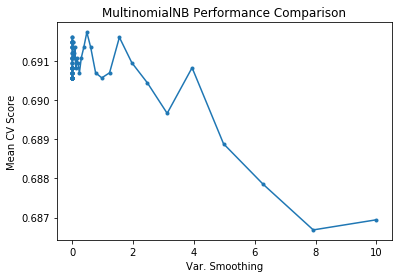

In [19]:
Smoothing_loss_plot(BoW_NB)

In [20]:
performance(BoW_NB,X_test_BoW, Y_test)

Classification report : 
               precision    recall  f1-score   support

           0       0.73      0.72      0.73       280
           1       0.57      0.61      0.59       277
           2       0.80      0.76      0.78       302

    accuracy                           0.70       859
   macro avg       0.70      0.70      0.70       859
weighted avg       0.71      0.70      0.70       859

Confusion matrix : 
 [[202  70   8]
 [ 60 169  48]
 [ 14  57 231]]
Test accuracy : 70.08%


In [21]:
# TF-IDF --> MultinomialNB -- > Accuracy: 71.25%

tfidf_NB = MultinomialNB_classifier(X_train_tfidf, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ....................................... alpha=10.0, total=   0.0s
[CV] alpha=7.924828983539173 .........................................
[CV] .......................... alpha=7.924828983539173, total=   0.0s
[CV] alpha=7.924828983539173 .........................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.944206059437656 .........................................
[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.944206059437656 .........................................
[CV] .......................... alpha=3.944206059437656, total=   0.0s
[CV] alpha=3.1257158496882362 ........................................
[CV] ......................... alpha=3.1257158496882362, total=   0.0s
[CV] alpha=3.1257158496882362 ........................................
[CV] ......................... alpha=3.1257158496882362, total=   0.0s
[CV] alpha=3.1257158496882362 ........................................
[CV] ......................... alpha=3.1257158496882362, total=   0.0s
[CV] alpha=3.1257158496882362 ........................................
[CV] ......................... alpha=3.1257158496882362, total=   0.0s
[CV] alpha=3.1257158496882362 ........................................
[CV] .

[CV] ........................ alpha=0.19179102616724888, total=   0.0s
[CV] alpha=0.19179102616724888 .......................................
[CV] ........................ alpha=0.19179102616724888, total=   0.0s
[CV] alpha=0.19179102616724888 .......................................
[CV] ........................ alpha=0.19179102616724888, total=   0.0s
[CV] alpha=0.19179102616724888 .......................................
[CV] ........................ alpha=0.19179102616724888, total=   0.0s
[CV] alpha=0.1519911082952934 ........................................
[CV] ......................... alpha=0.1519911082952934, total=   0.0s
[CV] alpha=0.1519911082952934 ........................................
[CV] ......................... alpha=0.1519911082952934, total=   0.0s
[CV] alpha=0.1519911082952934 ........................................
[CV] ......................... alpha=0.1519911082952934, total=   0.0s
[CV] alpha=0.1519911082952934 ........................................
[CV] .

[CV] ....................... alpha=0.007390722033525783, total=   0.0s
[CV] alpha=0.007390722033525783 ......................................
[CV] ....................... alpha=0.007390722033525783, total=   0.0s
[CV] alpha=0.005857020818056668 ......................................
[CV] ....................... alpha=0.005857020818056668, total=   0.0s
[CV] alpha=0.005857020818056668 ......................................
[CV] ....................... alpha=0.005857020818056668, total=   0.0s
[CV] alpha=0.005857020818056668 ......................................
[CV] ....................... alpha=0.005857020818056668, total=   0.0s
[CV] alpha=0.005857020818056668 ......................................
[CV] ....................... alpha=0.005857020818056668, total=   0.0s
[CV] alpha=0.005857020818056668 ......................................
[CV] ....................... alpha=0.005857020818056668, total=   0.0s
[CV] alpha=0.004641588833612777 ......................................
[CV] .

[CV] ..................... alpha=0.00035938136638046257, total=   0.0s
[CV] alpha=0.00035938136638046257 ....................................
[CV] ..................... alpha=0.00035938136638046257, total=   0.0s
[CV] alpha=0.00035938136638046257 ....................................
[CV] ..................... alpha=0.00035938136638046257, total=   0.0s
[CV] alpha=0.0002848035868435805 .....................................
[CV] ...................... alpha=0.0002848035868435805, total=   0.0s
[CV] alpha=0.0002848035868435805 .....................................
[CV] ...................... alpha=0.0002848035868435805, total=   0.0s
[CV] alpha=0.0002848035868435805 .....................................
[CV] ...................... alpha=0.0002848035868435805, total=   0.0s
[CV] alpha=0.0002848035868435805 .....................................
[CV] ...................... alpha=0.0002848035868435805, total=   0.0s
[CV] alpha=0.0002848035868435805 .....................................
[CV] .

[CV] ..................... alpha=1.3848863713938746e-05, total=   0.0s
[CV] alpha=1.3848863713938746e-05 ....................................
[CV] ..................... alpha=1.3848863713938746e-05, total=   0.0s
[CV] alpha=1.3848863713938746e-05 ....................................
[CV] ..................... alpha=1.3848863713938746e-05, total=   0.0s
[CV] alpha=1.3848863713938746e-05 ....................................
[CV] ..................... alpha=1.3848863713938746e-05, total=   0.0s
[CV] alpha=1.3848863713938746e-05 ....................................
[CV] ..................... alpha=1.3848863713938746e-05, total=   0.0s
[CV] alpha=1.0974987654930568e-05 ....................................
[CV] ..................... alpha=1.0974987654930568e-05, total=   0.0s
[CV] alpha=1.0974987654930568e-05 ....................................
[CV] ..................... alpha=1.0974987654930568e-05, total=   0.0s
[CV] alpha=1.0974987654930568e-05 ....................................
[CV] .

[CV] ...................... alpha=8.497534359086439e-07, total=   0.0s
[CV] alpha=8.497534359086439e-07 .....................................
[CV] ...................... alpha=8.497534359086439e-07, total=   0.0s
[CV] alpha=8.497534359086439e-07 .....................................
[CV] ...................... alpha=8.497534359086439e-07, total=   0.0s
[CV] alpha=8.497534359086439e-07 .....................................
[CV] ...................... alpha=8.497534359086439e-07, total=   0.0s
[CV] alpha=6.734150657750828e-07 .....................................
[CV] ...................... alpha=6.734150657750828e-07, total=   0.0s
[CV] alpha=6.734150657750828e-07 .....................................
[CV] ...................... alpha=6.734150657750828e-07, total=   0.0s
[CV] alpha=6.734150657750828e-07 .....................................
[CV] ...................... alpha=6.734150657750828e-07, total=   0.0s
[CV] alpha=6.734150657750828e-07 .....................................
[CV] .

[CV] ...................... alpha=4.132012400115334e-08, total=   0.0s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] ...................... alpha=4.132012400115334e-08, total=   0.0s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] ...................... alpha=4.132012400115334e-08, total=   0.0s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] ...................... alpha=4.132012400115334e-08, total=   0.0s
[CV] alpha=4.132012400115334e-08 .....................................
[CV] ...................... alpha=4.132012400115334e-08, total=   0.0s
[CV] alpha=3.274549162877732e-08 .....................................
[CV] ...................... alpha=3.274549162877732e-08, total=   0.0s
[CV] alpha=3.274549162877732e-08 .....................................
[CV] ...................... alpha=3.274549162877732e-08, total=   0.0s
[CV] alpha=3.274549162877732e-08 .....................................
[CV] .

[CV] ..................... alpha=3.1992671377973846e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.535364493970117e-09 .....................................
[CV] ...................... alpha=2.535364493970117e-09, total=   0.0s
[CV] alpha=2.009233002565046e-09 .....................................
[CV] ...................... alpha=2.009233002565046e-09, total=   0.0s
[CV] alpha=2.009233002565046e-09 .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.3s finished


Best Var.Smoothing : {'alpha': 1.9630406500402708}


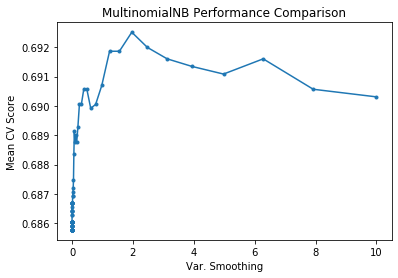

In [22]:
Smoothing_loss_plot(tfidf_NB)

In [23]:
performance(tfidf_NB,X_test_tfidf,Y_test)

Classification report : 
               precision    recall  f1-score   support

           0       0.73      0.71      0.72       280
           1       0.59      0.62      0.61       277
           2       0.81      0.79      0.80       302

    accuracy                           0.71       859
   macro avg       0.71      0.71      0.71       859
weighted avg       0.72      0.71      0.71       859

Confusion matrix : 
 [[200  71   9]
 [ 57 173  47]
 [ 16  47 239]]
Test accuracy : 71.25%


In [24]:
#TF-IDF - Artificial Neural Network -- > Accuracy: 68.8%

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

def build_ann(optimizer):
# Initializing the ANN
    classifier = Sequential()
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
    classifier.add(Dense(40, activation = 'relu', init = 'he_normal', input_shape = (X_train_tfidf.shape[1], )))
    classifier.add(Dropout(rate=0.5)) 
    classifier.add(Dense(20, activation = 'relu', init = 'he_normal', input_shape = (X_train_tfidf.shape[1], )))
    classifier.add(Dropout(rate=0.5)) 
# Adding the second hidden layer
# Notice that we do not need to specify input dim. 
    classifier.add(Dense(10, init = 'he_normal', activation = 'relu')) 
    classifier.add(Dropout(rate=0.5)) 
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
# We use the sigmoid because we want probability outcomes
    classifier.add(Dense(3, activation = 'softmax')) 
    classifier.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

classifier=KerasClassifier(build_fn=build_ann)
parameters={'batch_size':[128, 256, 512],
           'epochs':[10,25,50],
           'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,
                        param_grid=parameters,
                        scoring='accuracy',
                        refit = True,
                        verbose=2,
                        cv=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

grid_search=grid_search.fit(X_train_tfidf, Y_train, validation_split = 0.2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] batch_size=128, epochs=10, optimizer=adam .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Train on 4944 samples, validate on 1237 samples
Epoch 1/10
4944/4944 [==============================] - 2s 470us/step - loss: 1.0964 - accuracy: 0.3538 - val_loss: 1.0909 - val_accuracy: 0.4535
Epoch 2/10
4944/4944 [==============================] - 1s 114us/step - loss: 1.0706 - accuracy: 0.4051 - val_loss: 1.0545 - val_accuracy: 0.4624
Epoch 3/10
4944/4944 [==============================] - 1s 102us/step - loss: 1.0227 - accuracy: 0.4966 - val_loss: 0.9918 - val_accuracy: 0.5505
Epoch 4/10
4944/4944 [==============================] - 1s 154us/step - loss: 0.9612 - accuracy: 0.5564 - val_loss: 0.9361 - val_accuracy: 0.5675
Epoch 5/10
4944/4944 [==============================] - 1s 107us/step - loss: 0.9113 - accuracy: 0.5894 - val_loss: 0.9035 - val_accuracy: 0.5764
Epoch 6/10
4944/4944 [==============================] - 1s 105us/step - loss: 0.8677 - accuracy: 0.6072 - val_loss: 0.8750 - val_accuracy: 0.6055
Epoch 7/10
4944/4944 [==============================] - 0s 93us/step - loss

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


Train on 4944 samples, validate on 1237 samples
Epoch 1/10
4944/4944 [==============================] - 2s 409us/step - loss: 1.0987 - accuracy: 0.3406 - val_loss: 1.0963 - val_accuracy: 0.4091
Epoch 2/10
4944/4944 [==============================] - 0s 96us/step - loss: 1.0873 - accuracy: 0.3821 - val_loss: 1.0865 - val_accuracy: 0.3678
Epoch 3/10
4944/4944 [==============================] - 0s 92us/step - loss: 1.0568 - accuracy: 0.4239 - val_loss: 1.0492 - val_accuracy: 0.4519
Epoch 4/10
4944/4944 [==============================] - 0s 88us/step - loss: 1.0060 - accuracy: 0.4949 - val_loss: 0.9903 - val_accuracy: 0.4939
Epoch 5/10
4944/4944 [==============================] - 0s 87us/step - loss: 0.9522 - accuracy: 0.5227 - val_loss: 0.9408 - val_accuracy: 0.4939
Epoch 6/10
4944/4944 [==============================] - 0s 89us/step - loss: 0.8880 - accuracy: 0.5532 - val_loss: 0.9197 - val_accuracy: 0.4939
Epoch 7/10
4944/4944 [==============================] - 0s 89us/step - loss: 0.86

Train on 4944 samples, validate on 1237 samples
Epoch 1/10
4944/4944 [==============================] - 3s 525us/step - loss: 1.0985 - accuracy: 0.3378 - val_loss: 1.0976 - val_accuracy: 0.3646
Epoch 2/10
4944/4944 [==============================] - 1s 115us/step - loss: 1.0901 - accuracy: 0.3661 - val_loss: 1.0828 - val_accuracy: 0.4947
Epoch 3/10
4944/4944 [==============================] - 1s 114us/step - loss: 1.0741 - accuracy: 0.4084 - val_loss: 1.0494 - val_accuracy: 0.5699
Epoch 4/10
4944/4944 [==============================] - 1s 136us/step - loss: 1.0351 - accuracy: 0.4739 - val_loss: 0.9777 - val_accuracy: 0.6095
Epoch 5/10
4944/4944 [==============================] - 1s 129us/step - loss: 0.9794 - accuracy: 0.5275 - val_loss: 0.9013 - val_accuracy: 0.5966
Epoch 6/10
4944/4944 [==============================] - 1s 109us/step - loss: 0.9091 - accuracy: 0.5655 - val_loss: 0.8563 - val_accuracy: 0.5877
Epoch 7/10
4944/4944 [==============================] - 1s 121us/step - loss

Epoch 12/25
4944/4944 [==============================] - 0s 93us/step - loss: 0.6637 - accuracy: 0.7059 - val_loss: 0.7673 - val_accuracy: 0.6556
Epoch 13/25
4944/4944 [==============================] - 1s 107us/step - loss: 0.6436 - accuracy: 0.7108 - val_loss: 0.7678 - val_accuracy: 0.6621
Epoch 14/25
4944/4944 [==============================] - 1s 111us/step - loss: 0.6060 - accuracy: 0.7385 - val_loss: 0.7771 - val_accuracy: 0.6589
Epoch 15/25
4944/4944 [==============================] - 1s 128us/step - loss: 0.5853 - accuracy: 0.7431 - val_loss: 0.7835 - val_accuracy: 0.6637
Epoch 16/25
4944/4944 [==============================] - 1s 106us/step - loss: 0.5516 - accuracy: 0.7593 - val_loss: 0.8002 - val_accuracy: 0.6637
Epoch 17/25
4944/4944 [==============================] - 1s 115us/step - loss: 0.5376 - accuracy: 0.7609 - val_loss: 0.8092 - val_accuracy: 0.6621
Epoch 18/25
4944/4944 [==============================] - 1s 119us/step - loss: 0.5275 - accuracy: 0.7631 - val_loss: 0.

4945/4945 [==============================] - 1s 103us/step - loss: 0.5439 - accuracy: 0.8061 - val_loss: 0.8152 - val_accuracy: 0.6540
Epoch 16/25
4945/4945 [==============================] - 0s 98us/step - loss: 0.4986 - accuracy: 0.8253 - val_loss: 0.8452 - val_accuracy: 0.6556
Epoch 17/25
4945/4945 [==============================] - 1s 105us/step - loss: 0.4830 - accuracy: 0.8295 - val_loss: 0.8867 - val_accuracy: 0.6532
Epoch 18/25
4945/4945 [==============================] - 1s 103us/step - loss: 0.4554 - accuracy: 0.8447 - val_loss: 0.9406 - val_accuracy: 0.6492
Epoch 19/25
4945/4945 [==============================] - 1s 129us/step - loss: 0.4336 - accuracy: 0.8552 - val_loss: 0.9211 - val_accuracy: 0.6524
Epoch 20/25
4945/4945 [==============================] - 1s 110us/step - loss: 0.4104 - accuracy: 0.8578 - val_loss: 0.9768 - val_accuracy: 0.6427
Epoch 21/25
4945/4945 [==============================] - 1s 105us/step - loss: 0.3994 - accuracy: 0.8694 - val_loss: 0.9953 - val_a

4945/4945 [==============================] - 1s 138us/step - loss: 0.5434 - accuracy: 0.7862 - val_loss: 0.8184 - val_accuracy: 0.6532
Epoch 19/25
4945/4945 [==============================] - 1s 118us/step - loss: 0.5152 - accuracy: 0.7923 - val_loss: 0.8311 - val_accuracy: 0.6605
Epoch 20/25
4945/4945 [==============================] - 1s 111us/step - loss: 0.4947 - accuracy: 0.8006 - val_loss: 0.8479 - val_accuracy: 0.6532
Epoch 21/25
4945/4945 [==============================] - 1s 119us/step - loss: 0.4796 - accuracy: 0.8138 - val_loss: 0.8652 - val_accuracy: 0.6580
Epoch 22/25
4945/4945 [==============================] - 1s 125us/step - loss: 0.4699 - accuracy: 0.8129 - val_loss: 0.8913 - val_accuracy: 0.6621
Epoch 23/25
4945/4945 [==============================] - 1s 178us/step - loss: 0.4479 - accuracy: 0.8299 - val_loss: 0.9271 - val_accuracy: 0.6508
Epoch 24/25
4945/4945 [==============================] - 1s 160us/step - loss: 0.4293 - accuracy: 0.8459 - val_loss: 0.9486 - val_

4944/4944 [==============================] - 1s 129us/step - loss: 0.4512 - accuracy: 0.8133 - val_loss: 0.9816 - val_accuracy: 0.6354
Epoch 22/25
4944/4944 [==============================] - 1s 114us/step - loss: 0.4418 - accuracy: 0.8339 - val_loss: 0.9738 - val_accuracy: 0.6435
Epoch 23/25
4944/4944 [==============================] - 0s 97us/step - loss: 0.4291 - accuracy: 0.8319 - val_loss: 1.0198 - val_accuracy: 0.6411
Epoch 24/25
4944/4944 [==============================] - 1s 117us/step - loss: 0.4152 - accuracy: 0.8428 - val_loss: 1.0546 - val_accuracy: 0.6370
Epoch 25/25
4944/4944 [==============================] - 1s 125us/step - loss: 0.3991 - accuracy: 0.8455 - val_loss: 1.0974 - val_accuracy: 0.6427
[CV] ..... batch_size=128, epochs=25, optimizer=rmsprop, total=  21.8s
[CV] batch_size=128, epochs=25, optimizer=rmsprop ....................
Train on 4945 samples, validate on 1237 samples
Epoch 1/25
4945/4945 [==============================] - 3s 523us/step - loss: 1.0977 - a

4945/4945 [==============================] - 1s 105us/step - loss: 0.4242 - accuracy: 0.8192 - val_loss: 0.9818 - val_accuracy: 0.6419
Epoch 25/25
4945/4945 [==============================] - 1s 103us/step - loss: 0.4060 - accuracy: 0.8218 - val_loss: 1.0119 - val_accuracy: 0.6378
[CV] ..... batch_size=128, epochs=25, optimizer=rmsprop, total=  18.7s
[CV] batch_size=128, epochs=25, optimizer=rmsprop ....................
Train on 4945 samples, validate on 1237 samples
Epoch 1/25
4945/4945 [==============================] - 2s 461us/step - loss: 1.0978 - accuracy: 0.3434 - val_loss: 1.0941 - val_accuracy: 0.3953
Epoch 2/25
4945/4945 [==============================] - 0s 91us/step - loss: 1.0826 - accuracy: 0.3814 - val_loss: 1.0680 - val_accuracy: 0.5214
Epoch 3/25
4945/4945 [==============================] - 0s 91us/step - loss: 1.0548 - accuracy: 0.4188 - val_loss: 1.0209 - val_accuracy: 0.5901
Epoch 4/25
4945/4945 [==============================] - 0s 90us/step - loss: 1.0084 - accura

4944/4944 [==============================] - 1s 122us/step - loss: 0.3359 - accuracy: 0.8790 - val_loss: 1.3136 - val_accuracy: 0.6362
Epoch 28/50
4944/4944 [==============================] - 1s 104us/step - loss: 0.3293 - accuracy: 0.8794 - val_loss: 1.3682 - val_accuracy: 0.6322
Epoch 29/50
4944/4944 [==============================] - 1s 103us/step - loss: 0.3211 - accuracy: 0.8817 - val_loss: 1.3648 - val_accuracy: 0.6346
Epoch 30/50
4944/4944 [==============================] - 1s 105us/step - loss: 0.3061 - accuracy: 0.8914 - val_loss: 1.4112 - val_accuracy: 0.6322
Epoch 31/50
4944/4944 [==============================] - 1s 125us/step - loss: 0.2882 - accuracy: 0.9007 - val_loss: 1.4578 - val_accuracy: 0.6354
Epoch 32/50
4944/4944 [==============================] - 1s 112us/step - loss: 0.2975 - accuracy: 0.8954 - val_loss: 1.5544 - val_accuracy: 0.6330
Epoch 33/50
4944/4944 [==============================] - 1s 114us/step - loss: 0.2901 - accuracy: 0.8944 - val_loss: 1.5507 - val_

Epoch 32/50
4944/4944 [==============================] - 0s 95us/step - loss: 0.3086 - accuracy: 0.8956 - val_loss: 1.2757 - val_accuracy: 0.6435
Epoch 33/50
4944/4944 [==============================] - 0s 95us/step - loss: 0.3046 - accuracy: 0.8920 - val_loss: 1.3157 - val_accuracy: 0.6475
Epoch 34/50
4944/4944 [==============================] - 0s 94us/step - loss: 0.2942 - accuracy: 0.8995 - val_loss: 1.3316 - val_accuracy: 0.6435
Epoch 35/50
4944/4944 [==============================] - 0s 94us/step - loss: 0.2849 - accuracy: 0.9005 - val_loss: 1.3490 - val_accuracy: 0.6467
Epoch 36/50
4944/4944 [==============================] - 0s 94us/step - loss: 0.2870 - accuracy: 0.8987 - val_loss: 1.3809 - val_accuracy: 0.6411
Epoch 37/50
4944/4944 [==============================] - 0s 95us/step - loss: 0.2812 - accuracy: 0.8975 - val_loss: 1.4480 - val_accuracy: 0.6403
Epoch 38/50
4944/4944 [==============================] - 1s 106us/step - loss: 0.2838 - accuracy: 0.9033 - val_loss: 1.4535 

Epoch 37/50
4945/4945 [==============================] - 0s 95us/step - loss: 0.2702 - accuracy: 0.9183 - val_loss: 1.6292 - val_accuracy: 0.6475
Epoch 38/50
4945/4945 [==============================] - 0s 95us/step - loss: 0.2466 - accuracy: 0.9244 - val_loss: 1.7273 - val_accuracy: 0.6403
Epoch 39/50
4945/4945 [==============================] - 0s 95us/step - loss: 0.2650 - accuracy: 0.9171 - val_loss: 1.6879 - val_accuracy: 0.6492
Epoch 40/50
4945/4945 [==============================] - 0s 97us/step - loss: 0.2416 - accuracy: 0.9256 - val_loss: 1.7864 - val_accuracy: 0.6411
Epoch 41/50
4945/4945 [==============================] - 0s 95us/step - loss: 0.2344 - accuracy: 0.9292 - val_loss: 1.7976 - val_accuracy: 0.6516
Epoch 42/50
4945/4945 [==============================] - 0s 97us/step - loss: 0.2403 - accuracy: 0.9256 - val_loss: 1.8916 - val_accuracy: 0.6467
Epoch 43/50
4945/4945 [==============================] - 0s 95us/step - loss: 0.2413 - accuracy: 0.9244 - val_loss: 1.8843 -

Epoch 42/50
4945/4945 [==============================] - 0s 95us/step - loss: 0.2816 - accuracy: 0.9041 - val_loss: 1.8161 - val_accuracy: 0.6209
Epoch 43/50
4945/4945 [==============================] - 0s 94us/step - loss: 0.2703 - accuracy: 0.9124 - val_loss: 1.9586 - val_accuracy: 0.6120
Epoch 44/50
4945/4945 [==============================] - 0s 95us/step - loss: 0.2581 - accuracy: 0.9177 - val_loss: 1.9292 - val_accuracy: 0.6200
Epoch 45/50
4945/4945 [==============================] - 0s 95us/step - loss: 0.2685 - accuracy: 0.9098 - val_loss: 2.0418 - val_accuracy: 0.6112
Epoch 46/50
4945/4945 [==============================] - 0s 94us/step - loss: 0.2609 - accuracy: 0.9157 - val_loss: 1.8917 - val_accuracy: 0.6241
Epoch 47/50
4945/4945 [==============================] - 0s 95us/step - loss: 0.2390 - accuracy: 0.9223 - val_loss: 1.9649 - val_accuracy: 0.6217
Epoch 48/50
4945/4945 [==============================] - 0s 94us/step - loss: 0.2512 - accuracy: 0.9155 - val_loss: 2.0855 -

Epoch 47/50
4945/4945 [==============================] - 0s 97us/step - loss: 0.2485 - accuracy: 0.8999 - val_loss: 1.3444 - val_accuracy: 0.6661
Epoch 48/50
4945/4945 [==============================] - 0s 96us/step - loss: 0.2523 - accuracy: 0.9025 - val_loss: 1.3428 - val_accuracy: 0.6629
Epoch 49/50
4945/4945 [==============================] - 0s 98us/step - loss: 0.2321 - accuracy: 0.9072 - val_loss: 1.3843 - val_accuracy: 0.6669
Epoch 50/50
4945/4945 [==============================] - 0s 98us/step - loss: 0.2355 - accuracy: 0.9068 - val_loss: 1.4163 - val_accuracy: 0.6653
[CV] ........ batch_size=128, epochs=50, optimizer=adam, total=  31.4s
[CV] batch_size=128, epochs=50, optimizer=rmsprop ....................
Train on 4944 samples, validate on 1237 samples
Epoch 1/50
4944/4944 [==============================] - 2s 495us/step - loss: 1.0993 - accuracy: 0.3418 - val_loss: 1.0974 - val_accuracy: 0.3686
Epoch 2/50
4944/4944 [==============================] - 0s 99us/step - loss: 1.0

Train on 4944 samples, validate on 1237 samples
Epoch 1/50
4944/4944 [==============================] - 3s 517us/step - loss: 1.0983 - accuracy: 0.3430 - val_loss: 1.0972 - val_accuracy: 0.3872
Epoch 2/50
4944/4944 [==============================] - 0s 98us/step - loss: 1.0920 - accuracy: 0.3675 - val_loss: 1.0833 - val_accuracy: 0.5069
Epoch 3/50
4944/4944 [==============================] - 0s 98us/step - loss: 1.0678 - accuracy: 0.4187 - val_loss: 1.0272 - val_accuracy: 0.5651
Epoch 4/50
4944/4944 [==============================] - 0s 97us/step - loss: 1.0207 - accuracy: 0.4624 - val_loss: 0.9476 - val_accuracy: 0.5837
Epoch 5/50
4944/4944 [==============================] - 0s 98us/step - loss: 0.9556 - accuracy: 0.5083 - val_loss: 0.8815 - val_accuracy: 0.6047
Epoch 6/50
4944/4944 [==============================] - 0s 97us/step - loss: 0.9071 - accuracy: 0.5336 - val_loss: 0.8397 - val_accuracy: 0.6112
Epoch 7/50
4944/4944 [==============================] - 0s 98us/step - loss: 0.87

4945/4945 [==============================] - 0s 100us/step - loss: 0.9798 - accuracy: 0.4936 - val_loss: 0.9170 - val_accuracy: 0.6015
Epoch 6/50
4945/4945 [==============================] - 0s 99us/step - loss: 0.9061 - accuracy: 0.5620 - val_loss: 0.8410 - val_accuracy: 0.6087
Epoch 7/50
4945/4945 [==============================] - 0s 97us/step - loss: 0.8569 - accuracy: 0.5844 - val_loss: 0.8000 - val_accuracy: 0.6378
Epoch 8/50
4945/4945 [==============================] - 0s 98us/step - loss: 0.8153 - accuracy: 0.6129 - val_loss: 0.7757 - val_accuracy: 0.6556
Epoch 9/50
4945/4945 [==============================] - 0s 99us/step - loss: 0.7676 - accuracy: 0.6548 - val_loss: 0.7534 - val_accuracy: 0.6694
Epoch 10/50
4945/4945 [==============================] - 0s 98us/step - loss: 0.7084 - accuracy: 0.6863 - val_loss: 0.7458 - val_accuracy: 0.6661
Epoch 11/50
4945/4945 [==============================] - 0s 98us/step - loss: 0.6907 - accuracy: 0.6942 - val_loss: 0.7463 - val_accuracy: 

Epoch 10/50
4945/4945 [==============================] - 0s 98us/step - loss: 0.7346 - accuracy: 0.6514 - val_loss: 0.7991 - val_accuracy: 0.6128
Epoch 11/50
4945/4945 [==============================] - 0s 97us/step - loss: 0.7002 - accuracy: 0.6750 - val_loss: 0.8072 - val_accuracy: 0.6144
Epoch 12/50
4945/4945 [==============================] - 0s 98us/step - loss: 0.6795 - accuracy: 0.6934 - val_loss: 0.8268 - val_accuracy: 0.6128
Epoch 13/50
4945/4945 [==============================] - 0s 100us/step - loss: 0.6588 - accuracy: 0.7120 - val_loss: 0.8179 - val_accuracy: 0.6314
Epoch 14/50
4945/4945 [==============================] - 0s 99us/step - loss: 0.6269 - accuracy: 0.7304 - val_loss: 0.8267 - val_accuracy: 0.6306
Epoch 15/50
4945/4945 [==============================] - 0s 98us/step - loss: 0.5895 - accuracy: 0.7482 - val_loss: 0.8486 - val_accuracy: 0.6322
Epoch 16/50
4945/4945 [==============================] - 0s 97us/step - loss: 0.5730 - accuracy: 0.7608 - val_loss: 0.8699 

Epoch 15/50
4945/4945 [==============================] - 0s 97us/step - loss: 0.5718 - accuracy: 0.7939 - val_loss: 0.8157 - val_accuracy: 0.6839
Epoch 16/50
4945/4945 [==============================] - 0s 97us/step - loss: 0.5531 - accuracy: 0.8079 - val_loss: 0.8310 - val_accuracy: 0.6750
Epoch 17/50
4945/4945 [==============================] - 0s 97us/step - loss: 0.5376 - accuracy: 0.8103 - val_loss: 0.8405 - val_accuracy: 0.6718
Epoch 18/50
4945/4945 [==============================] - 0s 99us/step - loss: 0.5096 - accuracy: 0.8208 - val_loss: 0.8640 - val_accuracy: 0.6621
Epoch 19/50
4945/4945 [==============================] - 1s 116us/step - loss: 0.4867 - accuracy: 0.8342 - val_loss: 0.8847 - val_accuracy: 0.6645
Epoch 20/50
4945/4945 [==============================] - 1s 120us/step - loss: 0.4640 - accuracy: 0.8487 - val_loss: 0.9204 - val_accuracy: 0.6629
Epoch 21/50
4945/4945 [==============================] - 0s 97us/step - loss: 0.4332 - accuracy: 0.8588 - val_loss: 0.9636

4944/4944 [==============================] - 0s 73us/step - loss: 0.9755 - accuracy: 0.5249 - val_loss: 0.9140 - val_accuracy: 0.6419
Epoch 9/10
4944/4944 [==============================] - 0s 68us/step - loss: 0.9398 - accuracy: 0.5447 - val_loss: 0.8792 - val_accuracy: 0.6386
Epoch 10/10
4944/4944 [==============================] - 0s 65us/step - loss: 0.9041 - accuracy: 0.5771 - val_loss: 0.8461 - val_accuracy: 0.6419
[CV] ........ batch_size=256, epochs=10, optimizer=adam, total=  11.8s
[CV] batch_size=256, epochs=10, optimizer=adam .......................
Train on 4945 samples, validate on 1237 samples
Epoch 1/10
4945/4945 [==============================] - 2s 504us/step - loss: 1.0977 - accuracy: 0.3379 - val_loss: 1.0961 - val_accuracy: 0.3969
Epoch 2/10
4945/4945 [==============================] - 0s 75us/step - loss: 1.0897 - accuracy: 0.3776 - val_loss: 1.0859 - val_accuracy: 0.4454
Epoch 3/10
4945/4945 [==============================] - 0s 79us/step - loss: 1.0791 - accuracy

Epoch 8/10
4944/4944 [==============================] - 0s 67us/step - loss: 0.9352 - accuracy: 0.5532 - val_loss: 0.8925 - val_accuracy: 0.6403
Epoch 9/10
4944/4944 [==============================] - 0s 68us/step - loss: 0.8903 - accuracy: 0.5847 - val_loss: 0.8670 - val_accuracy: 0.6370
Epoch 10/10
4944/4944 [==============================] - 0s 67us/step - loss: 0.8673 - accuracy: 0.6082 - val_loss: 0.8477 - val_accuracy: 0.6443
[CV] ..... batch_size=256, epochs=10, optimizer=rmsprop, total=  12.6s
[CV] batch_size=256, epochs=10, optimizer=rmsprop ....................
Train on 4945 samples, validate on 1237 samples
Epoch 1/10
4945/4945 [==============================] - 3s 520us/step - loss: 1.0974 - accuracy: 0.3498 - val_loss: 1.0962 - val_accuracy: 0.3864
Epoch 2/10
4945/4945 [==============================] - 0s 66us/step - loss: 1.0909 - accuracy: 0.3780 - val_loss: 1.0891 - val_accuracy: 0.4066
Epoch 3/10
4945/4945 [==============================] - 0s 67us/step - loss: 1.0820

4944/4944 [==============================] - 0s 67us/step - loss: 0.5869 - accuracy: 0.7615 - val_loss: 0.7818 - val_accuracy: 0.6637
Epoch 20/25
4944/4944 [==============================] - 0s 68us/step - loss: 0.5653 - accuracy: 0.7747 - val_loss: 0.7945 - val_accuracy: 0.6597
Epoch 21/25
4944/4944 [==============================] - 0s 67us/step - loss: 0.5559 - accuracy: 0.7769 - val_loss: 0.8011 - val_accuracy: 0.6589
Epoch 22/25
4944/4944 [==============================] - 0s 67us/step - loss: 0.5373 - accuracy: 0.7803 - val_loss: 0.8191 - val_accuracy: 0.6564
Epoch 23/25
4944/4944 [==============================] - 0s 69us/step - loss: 0.5199 - accuracy: 0.7892 - val_loss: 0.8277 - val_accuracy: 0.6572
Epoch 24/25
4944/4944 [==============================] - 0s 66us/step - loss: 0.4940 - accuracy: 0.8020 - val_loss: 0.8427 - val_accuracy: 0.6572
Epoch 25/25
4944/4944 [==============================] - 0s 68us/step - loss: 0.4792 - accuracy: 0.8111 - val_loss: 0.8557 - val_accurac

Epoch 23/25
4945/4945 [==============================] - 0s 68us/step - loss: 0.5518 - accuracy: 0.7596 - val_loss: 0.8701 - val_accuracy: 0.6306
Epoch 24/25
4945/4945 [==============================] - 0s 67us/step - loss: 0.5332 - accuracy: 0.7652 - val_loss: 0.8611 - val_accuracy: 0.6443
Epoch 25/25
4945/4945 [==============================] - 0s 68us/step - loss: 0.4996 - accuracy: 0.7917 - val_loss: 0.8754 - val_accuracy: 0.6443
[CV] ........ batch_size=256, epochs=25, optimizer=adam, total=  18.9s
[CV] batch_size=256, epochs=25, optimizer=adam .......................
Train on 4945 samples, validate on 1237 samples
Epoch 1/25
4945/4945 [==============================] - 3s 575us/step - loss: 1.0991 - accuracy: 0.3327 - val_loss: 1.0961 - val_accuracy: 0.4147
Epoch 2/25
4945/4945 [==============================] - 0s 68us/step - loss: 1.0926 - accuracy: 0.3741 - val_loss: 1.0894 - val_accuracy: 0.5117
Epoch 3/25
4945/4945 [==============================] - 0s 69us/step - loss: 1.08

Train on 4944 samples, validate on 1237 samples
Epoch 1/25
4944/4944 [==============================] - 3s 609us/step - loss: 1.0997 - accuracy: 0.3477 - val_loss: 1.0925 - val_accuracy: 0.4276
Epoch 2/25
4944/4944 [==============================] - 0s 67us/step - loss: 1.0865 - accuracy: 0.3898 - val_loss: 1.0768 - val_accuracy: 0.4794
Epoch 3/25
4944/4944 [==============================] - 0s 68us/step - loss: 1.0633 - accuracy: 0.4211 - val_loss: 1.0418 - val_accuracy: 0.5384
Epoch 4/25
4944/4944 [==============================] - 0s 68us/step - loss: 1.0255 - accuracy: 0.4763 - val_loss: 0.9906 - val_accuracy: 0.5861
Epoch 5/25
4944/4944 [==============================] - 0s 68us/step - loss: 0.9844 - accuracy: 0.5038 - val_loss: 0.9372 - val_accuracy: 0.6152
Epoch 6/25
4944/4944 [==============================] - 0s 67us/step - loss: 0.9361 - accuracy: 0.5451 - val_loss: 0.8923 - val_accuracy: 0.6289
Epoch 7/25
4944/4944 [==============================] - 0s 68us/step - loss: 0.88

4945/4945 [==============================] - 0s 67us/step - loss: 1.0566 - accuracy: 0.4271 - val_loss: 1.0178 - val_accuracy: 0.5780
Epoch 5/25
4945/4945 [==============================] - 0s 68us/step - loss: 1.0207 - accuracy: 0.4884 - val_loss: 0.9691 - val_accuracy: 0.5869
Epoch 6/25
4945/4945 [==============================] - 0s 67us/step - loss: 0.9747 - accuracy: 0.5268 - val_loss: 0.9159 - val_accuracy: 0.5869
Epoch 7/25
4945/4945 [==============================] - 0s 68us/step - loss: 0.9416 - accuracy: 0.5379 - val_loss: 0.8833 - val_accuracy: 0.6087
Epoch 8/25
4945/4945 [==============================] - 0s 67us/step - loss: 0.9195 - accuracy: 0.5577 - val_loss: 0.8580 - val_accuracy: 0.6079
Epoch 9/25
4945/4945 [==============================] - 0s 67us/step - loss: 0.8851 - accuracy: 0.5820 - val_loss: 0.8332 - val_accuracy: 0.6265
Epoch 10/25
4945/4945 [==============================] - 0s 68us/step - loss: 0.8422 - accuracy: 0.5996 - val_loss: 0.8089 - val_accuracy: 0.

Epoch 8/25
4945/4945 [==============================] - 0s 70us/step - loss: 0.8854 - accuracy: 0.6038 - val_loss: 0.8487 - val_accuracy: 0.6031
Epoch 9/25
4945/4945 [==============================] - 0s 70us/step - loss: 0.8519 - accuracy: 0.6212 - val_loss: 0.8254 - val_accuracy: 0.6015
Epoch 10/25
4945/4945 [==============================] - 0s 70us/step - loss: 0.8189 - accuracy: 0.6406 - val_loss: 0.8093 - val_accuracy: 0.6128
Epoch 11/25
4945/4945 [==============================] - 0s 71us/step - loss: 0.7877 - accuracy: 0.6443 - val_loss: 0.7928 - val_accuracy: 0.6176
Epoch 12/25
4945/4945 [==============================] - 0s 74us/step - loss: 0.7742 - accuracy: 0.6473 - val_loss: 0.7875 - val_accuracy: 0.6233
Epoch 13/25
4945/4945 [==============================] - 0s 71us/step - loss: 0.7378 - accuracy: 0.6714 - val_loss: 0.7817 - val_accuracy: 0.6281
Epoch 14/25
4945/4945 [==============================] - 0s 70us/step - loss: 0.7347 - accuracy: 0.6696 - val_loss: 0.7804 - v

Epoch 38/50
4944/4944 [==============================] - 0s 69us/step - loss: 0.3598 - accuracy: 0.8528 - val_loss: 1.2192 - val_accuracy: 0.6217
Epoch 39/50
4944/4944 [==============================] - 0s 68us/step - loss: 0.3647 - accuracy: 0.8519 - val_loss: 1.2315 - val_accuracy: 0.6184
Epoch 40/50
4944/4944 [==============================] - 0s 83us/step - loss: 0.3543 - accuracy: 0.8517 - val_loss: 1.2686 - val_accuracy: 0.6249
Epoch 41/50
4944/4944 [==============================] - 0s 73us/step - loss: 0.3330 - accuracy: 0.8683 - val_loss: 1.2917 - val_accuracy: 0.6192
Epoch 42/50
4944/4944 [==============================] - 0s 75us/step - loss: 0.3356 - accuracy: 0.8647 - val_loss: 1.3283 - val_accuracy: 0.6192
Epoch 43/50
4944/4944 [==============================] - 0s 71us/step - loss: 0.3170 - accuracy: 0.8679 - val_loss: 1.3419 - val_accuracy: 0.6249
Epoch 44/50
4944/4944 [==============================] - 0s 68us/step - loss: 0.3217 - accuracy: 0.8663 - val_loss: 1.3945 -

Epoch 43/50
4944/4944 [==============================] - 0s 69us/step - loss: 0.3320 - accuracy: 0.8619 - val_loss: 1.4308 - val_accuracy: 0.6314
Epoch 44/50
4944/4944 [==============================] - 0s 70us/step - loss: 0.3237 - accuracy: 0.8629 - val_loss: 1.5021 - val_accuracy: 0.6306
Epoch 45/50
4944/4944 [==============================] - 0s 68us/step - loss: 0.3208 - accuracy: 0.8714 - val_loss: 1.4743 - val_accuracy: 0.6362
Epoch 46/50
4944/4944 [==============================] - 0s 69us/step - loss: 0.3136 - accuracy: 0.8710 - val_loss: 1.5356 - val_accuracy: 0.6322
Epoch 47/50
4944/4944 [==============================] - 0s 70us/step - loss: 0.3005 - accuracy: 0.8758 - val_loss: 1.6396 - val_accuracy: 0.6265
Epoch 48/50
4944/4944 [==============================] - 0s 70us/step - loss: 0.2901 - accuracy: 0.8784 - val_loss: 1.6038 - val_accuracy: 0.6306
Epoch 49/50
4944/4944 [==============================] - 0s 70us/step - loss: 0.2991 - accuracy: 0.8778 - val_loss: 1.6509 -

Epoch 48/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.2935 - accuracy: 0.8791 - val_loss: 1.3151 - val_accuracy: 0.6322
Epoch 49/50
4945/4945 [==============================] - 0s 69us/step - loss: 0.2885 - accuracy: 0.8809 - val_loss: 1.3588 - val_accuracy: 0.6338
Epoch 50/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.2879 - accuracy: 0.8807 - val_loss: 1.3767 - val_accuracy: 0.6322
[CV] ........ batch_size=256, epochs=50, optimizer=adam, total=  30.5s
[CV] batch_size=256, epochs=50, optimizer=adam .......................
Train on 4945 samples, validate on 1237 samples
Epoch 1/50
4945/4945 [==============================] - 3s 650us/step - loss: 1.0978 - accuracy: 0.3393 - val_loss: 1.0967 - val_accuracy: 0.3767
Epoch 2/50
4945/4945 [==============================] - 0s 71us/step - loss: 1.0938 - accuracy: 0.3624 - val_loss: 1.0934 - val_accuracy: 0.4406
Epoch 3/50
4945/4945 [==============================] - 0s 70us/step - loss: 1.08

4945/4945 [==============================] - 3s 625us/step - loss: 1.0990 - accuracy: 0.3442 - val_loss: 1.0957 - val_accuracy: 0.3703
Epoch 2/50
4945/4945 [==============================] - 0s 69us/step - loss: 1.0913 - accuracy: 0.3662 - val_loss: 1.0888 - val_accuracy: 0.3994
Epoch 3/50
4945/4945 [==============================] - 0s 86us/step - loss: 1.0774 - accuracy: 0.3905 - val_loss: 1.0704 - val_accuracy: 0.4382
Epoch 4/50
4945/4945 [==============================] - 0s 83us/step - loss: 1.0561 - accuracy: 0.4447 - val_loss: 1.0411 - val_accuracy: 0.5319
Epoch 5/50
4945/4945 [==============================] - 0s 69us/step - loss: 1.0223 - accuracy: 0.5072 - val_loss: 0.9974 - val_accuracy: 0.5335
Epoch 6/50
4945/4945 [==============================] - 0s 71us/step - loss: 0.9853 - accuracy: 0.5521 - val_loss: 0.9530 - val_accuracy: 0.5804
Epoch 7/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.9506 - accuracy: 0.5945 - val_loss: 0.9134 - val_accuracy: 0.

Epoch 6/50
4944/4944 [==============================] - 0s 70us/step - loss: 0.9696 - accuracy: 0.5032 - val_loss: 0.9138 - val_accuracy: 0.5990
Epoch 7/50
4944/4944 [==============================] - 0s 72us/step - loss: 0.9324 - accuracy: 0.5348 - val_loss: 0.8723 - val_accuracy: 0.5998
Epoch 8/50
4944/4944 [==============================] - 0s 88us/step - loss: 0.8878 - accuracy: 0.5702 - val_loss: 0.8413 - val_accuracy: 0.6031
Epoch 9/50
4944/4944 [==============================] - 0s 87us/step - loss: 0.8549 - accuracy: 0.5884 - val_loss: 0.8157 - val_accuracy: 0.6144
Epoch 10/50
4944/4944 [==============================] - 0s 70us/step - loss: 0.8222 - accuracy: 0.6137 - val_loss: 0.7998 - val_accuracy: 0.6241
Epoch 11/50
4944/4944 [==============================] - 0s 70us/step - loss: 0.7872 - accuracy: 0.6323 - val_loss: 0.7829 - val_accuracy: 0.6362
Epoch 12/50
4944/4944 [==============================] - 0s 70us/step - loss: 0.7592 - accuracy: 0.6602 - val_loss: 0.7720 - val

Epoch 11/50
4944/4944 [==============================] - 0s 87us/step - loss: 0.8805 - accuracy: 0.6110 - val_loss: 0.8583 - val_accuracy: 0.6556
Epoch 12/50
4944/4944 [==============================] - 0s 84us/step - loss: 0.8267 - accuracy: 0.6414 - val_loss: 0.8259 - val_accuracy: 0.6677
Epoch 13/50
4944/4944 [==============================] - 0s 74us/step - loss: 0.7973 - accuracy: 0.6535 - val_loss: 0.8141 - val_accuracy: 0.6686
Epoch 14/50
4944/4944 [==============================] - 0s 72us/step - loss: 0.7673 - accuracy: 0.6697 - val_loss: 0.7950 - val_accuracy: 0.6734
Epoch 15/50
4944/4944 [==============================] - 0s 70us/step - loss: 0.7317 - accuracy: 0.6966 - val_loss: 0.7870 - val_accuracy: 0.6686
Epoch 16/50
4944/4944 [==============================] - 0s 74us/step - loss: 0.7050 - accuracy: 0.7013 - val_loss: 0.7790 - val_accuracy: 0.6750
Epoch 17/50
4944/4944 [==============================] - 0s 71us/step - loss: 0.6757 - accuracy: 0.7229 - val_loss: 0.7937 -

Epoch 16/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.6774 - accuracy: 0.7037 - val_loss: 0.7847 - val_accuracy: 0.6249
Epoch 17/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.6605 - accuracy: 0.7250 - val_loss: 0.7856 - val_accuracy: 0.6192
Epoch 18/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.6373 - accuracy: 0.7296 - val_loss: 0.7894 - val_accuracy: 0.6249
Epoch 19/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.6270 - accuracy: 0.7377 - val_loss: 0.7912 - val_accuracy: 0.6362
Epoch 20/50
4945/4945 [==============================] - 0s 71us/step - loss: 0.5927 - accuracy: 0.7567 - val_loss: 0.8220 - val_accuracy: 0.6273
Epoch 21/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.5886 - accuracy: 0.7610 - val_loss: 0.8160 - val_accuracy: 0.6338
Epoch 22/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.5647 - accuracy: 0.7687 - val_loss: 0.8333 -

Epoch 21/50
4945/4945 [==============================] - 0s 71us/step - loss: 0.5375 - accuracy: 0.7842 - val_loss: 0.8580 - val_accuracy: 0.6403
Epoch 22/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.5335 - accuracy: 0.7739 - val_loss: 0.8591 - val_accuracy: 0.6395
Epoch 23/50
4945/4945 [==============================] - 0s 79us/step - loss: 0.5105 - accuracy: 0.7939 - val_loss: 0.8841 - val_accuracy: 0.6346
Epoch 24/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.5051 - accuracy: 0.7964 - val_loss: 0.8965 - val_accuracy: 0.6403
Epoch 25/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.4900 - accuracy: 0.8119 - val_loss: 0.9212 - val_accuracy: 0.6314
Epoch 26/50
4945/4945 [==============================] - 0s 70us/step - loss: 0.4827 - accuracy: 0.8099 - val_loss: 0.9407 - val_accuracy: 0.6362
Epoch 27/50
4945/4945 [==============================] - 0s 72us/step - loss: 0.4698 - accuracy: 0.8162 - val_loss: 0.9724 -

Epoch 26/50
4945/4945 [==============================] - 0s 72us/step - loss: 0.4878 - accuracy: 0.8148 - val_loss: 0.8458 - val_accuracy: 0.6702
Epoch 27/50
4945/4945 [==============================] - 0s 71us/step - loss: 0.4736 - accuracy: 0.8224 - val_loss: 0.8612 - val_accuracy: 0.6710
Epoch 28/50
4945/4945 [==============================] - 0s 73us/step - loss: 0.4693 - accuracy: 0.8220 - val_loss: 0.8801 - val_accuracy: 0.6726
Epoch 29/50
4945/4945 [==============================] - 0s 76us/step - loss: 0.4464 - accuracy: 0.8224 - val_loss: 0.8687 - val_accuracy: 0.6702
Epoch 30/50
4945/4945 [==============================] - 0s 71us/step - loss: 0.4276 - accuracy: 0.8485 - val_loss: 0.9247 - val_accuracy: 0.6750
Epoch 31/50
4945/4945 [==============================] - 0s 72us/step - loss: 0.4230 - accuracy: 0.8441 - val_loss: 0.9046 - val_accuracy: 0.6750
Epoch 32/50
4945/4945 [==============================] - 0s 73us/step - loss: 0.4077 - accuracy: 0.8546 - val_loss: 0.9437 -

4945/4945 [==============================] - 0s 49us/step - loss: 1.0031 - accuracy: 0.4904 - val_loss: 0.9706 - val_accuracy: 0.5950
Epoch 9/10
4945/4945 [==============================] - 0s 48us/step - loss: 0.9885 - accuracy: 0.4950 - val_loss: 0.9417 - val_accuracy: 0.6031
Epoch 10/10
4945/4945 [==============================] - 0s 49us/step - loss: 0.9599 - accuracy: 0.5221 - val_loss: 0.9153 - val_accuracy: 0.6095
[CV] ........ batch_size=512, epochs=10, optimizer=adam, total=  16.6s
[CV] batch_size=512, epochs=10, optimizer=adam .......................
Train on 4945 samples, validate on 1237 samples
Epoch 1/10
4945/4945 [==============================] - 3s 657us/step - loss: 1.0985 - accuracy: 0.3414 - val_loss: 1.0977 - val_accuracy: 0.3808
Epoch 2/10
4945/4945 [==============================] - 0s 48us/step - loss: 1.0976 - accuracy: 0.3474 - val_loss: 1.0972 - val_accuracy: 0.3614
Epoch 3/10
4945/4945 [==============================] - 0s 49us/step - loss: 1.0957 - accuracy

Epoch 8/10
4945/4945 [==============================] - 0s 49us/step - loss: 0.9945 - accuracy: 0.5043 - val_loss: 0.9521 - val_accuracy: 0.6200
Epoch 9/10
4945/4945 [==============================] - 0s 49us/step - loss: 0.9678 - accuracy: 0.5132 - val_loss: 0.9157 - val_accuracy: 0.6289
Epoch 10/10
4945/4945 [==============================] - 0s 48us/step - loss: 0.9383 - accuracy: 0.5496 - val_loss: 0.8848 - val_accuracy: 0.6168
[CV] ..... batch_size=512, epochs=10, optimizer=rmsprop, total=  18.5s
[CV] batch_size=512, epochs=10, optimizer=rmsprop ....................
Train on 4945 samples, validate on 1237 samples
Epoch 1/10
4945/4945 [==============================] - 4s 780us/step - loss: 1.0999 - accuracy: 0.3367 - val_loss: 1.0967 - val_accuracy: 0.3800
Epoch 2/10
4945/4945 [==============================] - 0s 49us/step - loss: 1.0971 - accuracy: 0.3450 - val_loss: 1.0946 - val_accuracy: 0.4406
Epoch 3/10
4945/4945 [==============================] - 0s 54us/step - loss: 1.0931

4944/4944 [==============================] - 0s 56us/step - loss: 1.0842 - accuracy: 0.3685 - val_loss: 1.0811 - val_accuracy: 0.3573
Epoch 5/25
4944/4944 [==============================] - 0s 55us/step - loss: 1.0758 - accuracy: 0.3851 - val_loss: 1.0681 - val_accuracy: 0.4333
Epoch 6/25
4944/4944 [==============================] - 0s 57us/step - loss: 1.0615 - accuracy: 0.4335 - val_loss: 1.0525 - val_accuracy: 0.4349
Epoch 7/25
4944/4944 [==============================] - 0s 51us/step - loss: 1.0449 - accuracy: 0.4616 - val_loss: 1.0335 - val_accuracy: 0.4697
Epoch 8/25
4944/4944 [==============================] - 0s 50us/step - loss: 1.0237 - accuracy: 0.4846 - val_loss: 1.0120 - val_accuracy: 0.5036
Epoch 9/25
4944/4944 [==============================] - 0s 49us/step - loss: 1.0058 - accuracy: 0.4972 - val_loss: 0.9916 - val_accuracy: 0.5400
Epoch 10/25
4944/4944 [==============================] - 0s 49us/step - loss: 0.9882 - accuracy: 0.5218 - val_loss: 0.9687 - val_accuracy: 0.

Epoch 8/25
4945/4945 [==============================] - 0s 50us/step - loss: 1.0153 - accuracy: 0.4959 - val_loss: 0.9833 - val_accuracy: 0.6265
Epoch 9/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.9992 - accuracy: 0.5139 - val_loss: 0.9549 - val_accuracy: 0.6540
Epoch 10/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.9783 - accuracy: 0.5399 - val_loss: 0.9294 - val_accuracy: 0.6597
Epoch 11/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.9504 - accuracy: 0.5573 - val_loss: 0.9034 - val_accuracy: 0.6540
Epoch 12/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.9275 - accuracy: 0.5806 - val_loss: 0.8818 - val_accuracy: 0.6686
Epoch 13/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.9034 - accuracy: 0.5962 - val_loss: 0.8600 - val_accuracy: 0.6774
Epoch 14/25
4945/4945 [==============================] - 0s 61us/step - loss: 0.8823 - accuracy: 0.6148 - val_loss: 0.8404 - v

4944/4944 [==============================] - 0s 50us/step - loss: 0.8941 - accuracy: 0.5744 - val_loss: 0.8533 - val_accuracy: 0.6168
Epoch 12/25
4944/4944 [==============================] - 0s 49us/step - loss: 0.8773 - accuracy: 0.5868 - val_loss: 0.8288 - val_accuracy: 0.6281
Epoch 13/25
4944/4944 [==============================] - 0s 49us/step - loss: 0.8451 - accuracy: 0.6086 - val_loss: 0.8096 - val_accuracy: 0.6411
Epoch 14/25
4944/4944 [==============================] - 0s 49us/step - loss: 0.8220 - accuracy: 0.6254 - val_loss: 0.7972 - val_accuracy: 0.6403
Epoch 15/25
4944/4944 [==============================] - 0s 49us/step - loss: 0.7975 - accuracy: 0.6357 - val_loss: 0.7834 - val_accuracy: 0.6532
Epoch 16/25
4944/4944 [==============================] - 0s 50us/step - loss: 0.7833 - accuracy: 0.6434 - val_loss: 0.7744 - val_accuracy: 0.6556
Epoch 17/25
4944/4944 [==============================] - 0s 49us/step - loss: 0.7505 - accuracy: 0.6657 - val_loss: 0.7678 - val_accurac

Epoch 15/25
4945/4945 [==============================] - 0s 49us/step - loss: 0.8949 - accuracy: 0.5913 - val_loss: 0.8589 - val_accuracy: 0.6524
Epoch 16/25
4945/4945 [==============================] - 0s 49us/step - loss: 0.8702 - accuracy: 0.6111 - val_loss: 0.8400 - val_accuracy: 0.6500
Epoch 17/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.8373 - accuracy: 0.6421 - val_loss: 0.8190 - val_accuracy: 0.6524
Epoch 18/25
4945/4945 [==============================] - 0s 49us/step - loss: 0.8205 - accuracy: 0.6455 - val_loss: 0.8066 - val_accuracy: 0.6508
Epoch 19/25
4945/4945 [==============================] - 0s 49us/step - loss: 0.7868 - accuracy: 0.6599 - val_loss: 0.7897 - val_accuracy: 0.6564
Epoch 20/25
4945/4945 [==============================] - 0s 49us/step - loss: 0.7520 - accuracy: 0.6859 - val_loss: 0.7825 - val_accuracy: 0.6524
Epoch 21/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.7437 - accuracy: 0.6847 - val_loss: 0.7704 -

4945/4945 [==============================] - 0s 50us/step - loss: 0.8683 - accuracy: 0.6700 - val_loss: 0.8570 - val_accuracy: 0.6823
Epoch 19/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.8392 - accuracy: 0.6863 - val_loss: 0.8432 - val_accuracy: 0.6847
Epoch 20/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.8292 - accuracy: 0.6912 - val_loss: 0.8356 - val_accuracy: 0.6863
Epoch 21/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.7954 - accuracy: 0.7137 - val_loss: 0.8270 - val_accuracy: 0.6839
Epoch 22/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.7844 - accuracy: 0.7167 - val_loss: 0.8196 - val_accuracy: 0.6831
Epoch 23/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.7638 - accuracy: 0.7256 - val_loss: 0.8132 - val_accuracy: 0.6871
Epoch 24/25
4945/4945 [==============================] - 0s 50us/step - loss: 0.7499 - accuracy: 0.7444 - val_loss: 0.8090 - val_accurac

Epoch 48/50
4944/4944 [==============================] - 0s 50us/step - loss: 0.3993 - accuracy: 0.8649 - val_loss: 1.1243 - val_accuracy: 0.6443
Epoch 49/50
4944/4944 [==============================] - 0s 51us/step - loss: 0.3689 - accuracy: 0.8833 - val_loss: 1.1600 - val_accuracy: 0.6419
Epoch 50/50
4944/4944 [==============================] - 0s 50us/step - loss: 0.3736 - accuracy: 0.8875 - val_loss: 1.1686 - val_accuracy: 0.6459
[CV] ........ batch_size=512, epochs=50, optimizer=adam, total=  30.4s
[CV] batch_size=512, epochs=50, optimizer=adam .......................
Train on 4944 samples, validate on 1237 samples
Epoch 1/50
4944/4944 [==============================] - 4s 758us/step - loss: 1.0998 - accuracy: 0.3370 - val_loss: 1.0976 - val_accuracy: 0.3589
Epoch 2/50
4944/4944 [==============================] - 0s 50us/step - loss: 1.0972 - accuracy: 0.3467 - val_loss: 1.0966 - val_accuracy: 0.3977
Epoch 3/50
4944/4944 [==============================] - 0s 50us/step - loss: 1.09

4945/4945 [==============================] - 4s 771us/step - loss: 1.1005 - accuracy: 0.3365 - val_loss: 1.0968 - val_accuracy: 0.3775
Epoch 2/50
4945/4945 [==============================] - 0s 52us/step - loss: 1.0964 - accuracy: 0.3460 - val_loss: 1.0954 - val_accuracy: 0.4422
Epoch 3/50
4945/4945 [==============================] - 0s 50us/step - loss: 1.0925 - accuracy: 0.3838 - val_loss: 1.0918 - val_accuracy: 0.4705
Epoch 4/50
4945/4945 [==============================] - 0s 51us/step - loss: 1.0866 - accuracy: 0.3953 - val_loss: 1.0841 - val_accuracy: 0.4859
Epoch 5/50
4945/4945 [==============================] - 0s 50us/step - loss: 1.0792 - accuracy: 0.4047 - val_loss: 1.0711 - val_accuracy: 0.4859
Epoch 6/50
4945/4945 [==============================] - 0s 50us/step - loss: 1.0652 - accuracy: 0.4340 - val_loss: 1.0540 - val_accuracy: 0.5449
Epoch 7/50
4945/4945 [==============================] - 0s 50us/step - loss: 1.0499 - accuracy: 0.4728 - val_loss: 1.0324 - val_accuracy: 0.

Epoch 6/50
4945/4945 [==============================] - 0s 50us/step - loss: 1.0174 - accuracy: 0.4971 - val_loss: 0.9886 - val_accuracy: 0.5659
Epoch 7/50
4945/4945 [==============================] - 0s 52us/step - loss: 0.9928 - accuracy: 0.4952 - val_loss: 0.9537 - val_accuracy: 0.5732
Epoch 8/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.9670 - accuracy: 0.5137 - val_loss: 0.9248 - val_accuracy: 0.5853
Epoch 9/50
4945/4945 [==============================] - 0s 52us/step - loss: 0.9299 - accuracy: 0.5523 - val_loss: 0.8945 - val_accuracy: 0.5934
Epoch 10/50
4945/4945 [==============================] - 0s 52us/step - loss: 0.9067 - accuracy: 0.5553 - val_loss: 0.8717 - val_accuracy: 0.6039
Epoch 11/50
4945/4945 [==============================] - 0s 50us/step - loss: 0.8735 - accuracy: 0.5749 - val_loss: 0.8479 - val_accuracy: 0.6071
Epoch 12/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.8388 - accuracy: 0.5984 - val_loss: 0.8310 - val

Epoch 11/50
4945/4945 [==============================] - 0s 50us/step - loss: 0.9433 - accuracy: 0.5513 - val_loss: 0.8952 - val_accuracy: 0.6677
Epoch 12/50
4945/4945 [==============================] - 0s 50us/step - loss: 0.9184 - accuracy: 0.5610 - val_loss: 0.8615 - val_accuracy: 0.6823
Epoch 13/50
4945/4945 [==============================] - 0s 50us/step - loss: 0.9028 - accuracy: 0.5755 - val_loss: 0.8368 - val_accuracy: 0.6783
Epoch 14/50
4945/4945 [==============================] - 0s 50us/step - loss: 0.8592 - accuracy: 0.6154 - val_loss: 0.8147 - val_accuracy: 0.6815
Epoch 15/50
4945/4945 [==============================] - 0s 50us/step - loss: 0.8357 - accuracy: 0.6186 - val_loss: 0.7875 - val_accuracy: 0.6807
Epoch 16/50
4945/4945 [==============================] - 0s 50us/step - loss: 0.8121 - accuracy: 0.6394 - val_loss: 0.7725 - val_accuracy: 0.6799
Epoch 17/50
4945/4945 [==============================] - 0s 50us/step - loss: 0.7815 - accuracy: 0.6586 - val_loss: 0.7594 -

Epoch 16/50
4944/4944 [==============================] - 0s 51us/step - loss: 0.8304 - accuracy: 0.6212 - val_loss: 0.8577 - val_accuracy: 0.6403
Epoch 17/50
4944/4944 [==============================] - 0s 52us/step - loss: 0.8130 - accuracy: 0.6305 - val_loss: 0.8462 - val_accuracy: 0.6451
Epoch 18/50
4944/4944 [==============================] - 0s 51us/step - loss: 0.7843 - accuracy: 0.6509 - val_loss: 0.8356 - val_accuracy: 0.6556
Epoch 19/50
4944/4944 [==============================] - 0s 51us/step - loss: 0.7729 - accuracy: 0.6594 - val_loss: 0.8304 - val_accuracy: 0.6556
Epoch 20/50
4944/4944 [==============================] - 0s 51us/step - loss: 0.7438 - accuracy: 0.6650 - val_loss: 0.8262 - val_accuracy: 0.6508
Epoch 21/50
4944/4944 [==============================] - 0s 51us/step - loss: 0.7275 - accuracy: 0.6782 - val_loss: 0.8233 - val_accuracy: 0.6556
Epoch 22/50
4944/4944 [==============================] - 0s 51us/step - loss: 0.7176 - accuracy: 0.6877 - val_loss: 0.8190 -

Epoch 21/50
4944/4944 [==============================] - 0s 52us/step - loss: 0.7446 - accuracy: 0.6329 - val_loss: 0.8953 - val_accuracy: 0.5594
Epoch 22/50
4944/4944 [==============================] - 0s 52us/step - loss: 0.7400 - accuracy: 0.6541 - val_loss: 0.9032 - val_accuracy: 0.5724
Epoch 23/50
4944/4944 [==============================] - 0s 51us/step - loss: 0.7269 - accuracy: 0.6487 - val_loss: 0.9000 - val_accuracy: 0.5772
Epoch 24/50
4944/4944 [==============================] - 0s 55us/step - loss: 0.6970 - accuracy: 0.6606 - val_loss: 0.9089 - val_accuracy: 0.5926
Epoch 25/50
4944/4944 [==============================] - 0s 62us/step - loss: 0.6847 - accuracy: 0.6723 - val_loss: 0.9205 - val_accuracy: 0.5918
Epoch 26/50
4944/4944 [==============================] - 0s 61us/step - loss: 0.6788 - accuracy: 0.6681 - val_loss: 0.9357 - val_accuracy: 0.6039
Epoch 27/50
4944/4944 [==============================] - 0s 60us/step - loss: 0.6555 - accuracy: 0.6748 - val_loss: 0.9300 -

Epoch 26/50
4945/4945 [==============================] - 0s 62us/step - loss: 0.6193 - accuracy: 0.7462 - val_loss: 0.7466 - val_accuracy: 0.6718
Epoch 27/50
4945/4945 [==============================] - 0s 57us/step - loss: 0.6037 - accuracy: 0.7587 - val_loss: 0.7503 - val_accuracy: 0.6702
Epoch 28/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.5941 - accuracy: 0.7596 - val_loss: 0.7505 - val_accuracy: 0.6686
Epoch 29/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.5843 - accuracy: 0.7648 - val_loss: 0.7527 - val_accuracy: 0.6718
Epoch 30/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.5437 - accuracy: 0.7907 - val_loss: 0.7622 - val_accuracy: 0.6669
Epoch 31/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.5407 - accuracy: 0.7925 - val_loss: 0.7651 - val_accuracy: 0.6702
Epoch 32/50
4945/4945 [==============================] - 0s 50us/step - loss: 0.5301 - accuracy: 0.7897 - val_loss: 0.7733 -

Epoch 31/50
4945/4945 [==============================] - 0s 52us/step - loss: 0.6008 - accuracy: 0.7747 - val_loss: 0.7960 - val_accuracy: 0.6435
Epoch 32/50
4945/4945 [==============================] - 0s 52us/step - loss: 0.5795 - accuracy: 0.7854 - val_loss: 0.7954 - val_accuracy: 0.6467
Epoch 33/50
4945/4945 [==============================] - 0s 52us/step - loss: 0.5643 - accuracy: 0.7978 - val_loss: 0.8037 - val_accuracy: 0.6427
Epoch 34/50
4945/4945 [==============================] - 0s 52us/step - loss: 0.5592 - accuracy: 0.8038 - val_loss: 0.8137 - val_accuracy: 0.6443
Epoch 35/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.5250 - accuracy: 0.8063 - val_loss: 0.8222 - val_accuracy: 0.6435
Epoch 36/50
4945/4945 [==============================] - 0s 52us/step - loss: 0.5276 - accuracy: 0.8166 - val_loss: 0.8341 - val_accuracy: 0.6435
Epoch 37/50
4945/4945 [==============================] - 0s 52us/step - loss: 0.5231 - accuracy: 0.8164 - val_loss: 0.8446 -

Epoch 36/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.4740 - accuracy: 0.8198 - val_loss: 0.7926 - val_accuracy: 0.6597
Epoch 37/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.4713 - accuracy: 0.8235 - val_loss: 0.8048 - val_accuracy: 0.6540
Epoch 38/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.4558 - accuracy: 0.8261 - val_loss: 0.8148 - val_accuracy: 0.6580
Epoch 39/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.4479 - accuracy: 0.8239 - val_loss: 0.8227 - val_accuracy: 0.6597
Epoch 40/50
4945/4945 [==============================] - 0s 52us/step - loss: 0.4270 - accuracy: 0.8376 - val_loss: 0.8436 - val_accuracy: 0.6597
Epoch 41/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.4303 - accuracy: 0.8425 - val_loss: 0.8515 - val_accuracy: 0.6613
Epoch 42/50
4945/4945 [==============================] - 0s 51us/step - loss: 0.4159 - accuracy: 0.8423 - val_loss: 0.8580 -

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 32.3min finished


Train on 6181 samples, validate on 1546 samples
Epoch 1/25
6181/6181 [==============================] - 4s 674us/step - loss: 1.0991 - accuracy: 0.3313 - val_loss: 1.0956 - val_accuracy: 0.4030
Epoch 2/25
6181/6181 [==============================] - 0s 53us/step - loss: 1.0923 - accuracy: 0.3639 - val_loss: 1.0902 - val_accuracy: 0.3894
Epoch 3/25
6181/6181 [==============================] - 0s 52us/step - loss: 1.0843 - accuracy: 0.3883 - val_loss: 1.0811 - val_accuracy: 0.4347
Epoch 4/25
6181/6181 [==============================] - 0s 53us/step - loss: 1.0764 - accuracy: 0.4028 - val_loss: 1.0646 - val_accuracy: 0.5168
Epoch 5/25
6181/6181 [==============================] - 0s 53us/step - loss: 1.0561 - accuracy: 0.4365 - val_loss: 1.0368 - val_accuracy: 0.5582
Epoch 6/25
6181/6181 [==============================] - 0s 53us/step - loss: 1.0292 - accuracy: 0.4693 - val_loss: 0.9995 - val_accuracy: 0.5737
Epoch 7/25
6181/6181 [==============================] - 0s 53us/step - loss: 1.00

In [25]:
grid_search.best_params_

{'batch_size': 512, 'epochs': 25, 'optimizer': 'rmsprop'}

In [26]:
classifier = build_ann(optimizer = 'adam')
classifier.summary()

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_365 (Dense)            (None, 40)                80040     
_________________________________________________________________
dropout_274 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_366 (Dense)            (None, 20)                820       
_________________________________________________________________
dropout_275 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_367 (Dense)            (None, 10)                210       
_________________________________________________________________
dropout_276 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_368 (Dense)            (None, 3)               

In [27]:
history = classifier.fit(X_train_tfidf, Y_train, batch_size=512, epochs=25, validation_split=0.2, verbose=2,shuffle= True,callbacks = [learning_rate_reduction])

Train on 6181 samples, validate on 1546 samples
Epoch 1/25
 - 4s - loss: 1.0992 - accuracy: 0.3362 - val_loss: 1.0954 - val_accuracy: 0.4282
Epoch 2/25
 - 0s - loss: 1.0960 - accuracy: 0.3435 - val_loss: 1.0924 - val_accuracy: 0.4754
Epoch 3/25
 - 0s - loss: 1.0895 - accuracy: 0.3771 - val_loss: 1.0860 - val_accuracy: 0.5343
Epoch 4/25
 - 0s - loss: 1.0841 - accuracy: 0.4020 - val_loss: 1.0728 - val_accuracy: 0.5511
Epoch 5/25
 - 0s - loss: 1.0682 - accuracy: 0.4205 - val_loss: 1.0504 - val_accuracy: 0.6054
Epoch 6/25
 - 0s - loss: 1.0523 - accuracy: 0.4363 - val_loss: 1.0210 - val_accuracy: 0.6404
Epoch 7/25
 - 0s - loss: 1.0299 - accuracy: 0.4527 - val_loss: 0.9905 - val_accuracy: 0.6307
Epoch 8/25
 - 0s - loss: 1.0091 - accuracy: 0.4745 - val_loss: 0.9646 - val_accuracy: 0.6449
Epoch 9/25
 - 0s - loss: 0.9870 - accuracy: 0.5017 - val_loss: 0.9313 - val_accuracy: 0.6527
Epoch 10/25
 - 0s - loss: 0.9545 - accuracy: 0.5245 - val_loss: 0.9020 - val_accuracy: 0.6468
Epoch 11/25
 - 0s - l

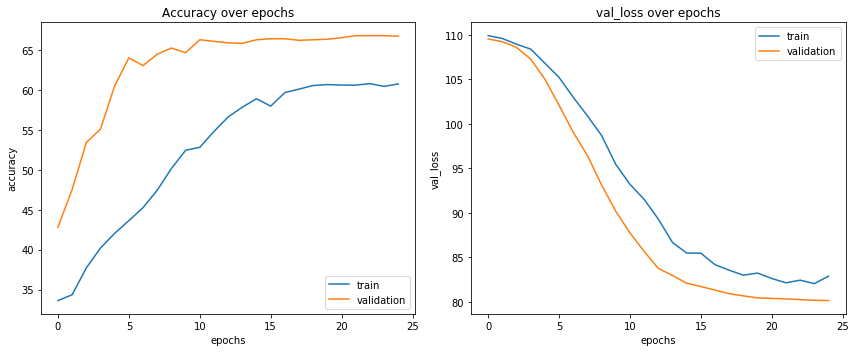

In [28]:
def plot_acc_loss(history):
    def plot_acc(history):
        plt.plot(np.array(history.history['accuracy']) * 100)
        plt.plot(np.array(history.history['val_accuracy']) * 100)
        plt.ylabel('accuracy')
        plt.xlabel('epochs')
        plt.legend(['train', 'validation'])
        plt.title('Accuracy over epochs')
    
    def plot_loss(history):
        plt.plot(np.array(history.history['loss']) * 100)
        plt.plot(np.array(history.history['val_loss']) * 100)
        plt.ylabel('val_loss')
        plt.xlabel('epochs')
        plt.legend(['train', 'validation'])
        plt.title('val_loss over epochs')
        
    plt.subplots(1,2,figsize=(12,5))
    plt.subplot(1, 2, 1)
    plot_acc(history)

    plt.subplot(1, 2, 2)
    plot_loss(history)
    plt.tight_layout()
    plt.show()
    
plot_acc_loss(history)

In [29]:
def performance_nn(classifier,X_test,Y_test):
    yprob = classifier.predict(X_test)
    yhat = yprob.argmax(axis=1)
    acc_pct = np.around(((confusion_matrix(Y_test,yhat)[0][0]+confusion_matrix(Y_test,yhat)[1][1]+confusion_matrix(Y_test,yhat)[2][2])/confusion_matrix(Y_test,yhat).sum())*100, decimals=2)
    print('Classification report : \n',classification_report(Y_test, yhat))
    print('Confusion matrix : \n',confusion_matrix(Y_test, yhat))
    return print('Test accuracy : {}%'.format(acc_pct))

In [30]:
performance_nn(classifier,X_test_tfidf,Y_test)

Classification report : 
               precision    recall  f1-score   support

           0       0.70      0.77      0.73       280
           1       0.59      0.48      0.53       277
           2       0.74      0.80      0.77       302

    accuracy                           0.69       859
   macro avg       0.68      0.68      0.68       859
weighted avg       0.68      0.69      0.68       859

Confusion matrix : 
 [[216  48  16]
 [ 77 132  68]
 [ 17  42 243]]
Test accuracy : 68.8%


In [31]:
# LSTM

In [32]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop_words.update(punctuation)
stop_words.update('’')
stop_words.update('“')
stop_words.update('”')

contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

def contractions_re(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    return text 

#Removing the stopwords from text
def remove_stopwords(s):
    words = str(s).lower()
    words = word_tokenize(words)
    return [w for w in words if not w in stop_words]

#lemmatization
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_tokens(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(sentence)  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(WordNetLemmatizer().lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

# Removing URL's
def remove_URL(text):
    return re.sub(r'http\S+', '', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        u"\U0001F913"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_stopwords(s):
    words = str(s).lower()
    words = word_tokenize(words)
    return [w for w in words if not w in stop_words]

# Remove the noisy text
def denoise_text(text):
    text = [contractions_re(x) for x in text]
    text = [remove_stopwords(x) for x in text]
    text = [lemmatize_tokens(x) for x in text]
    text = [remove_URL(x) for x in text] 
    text = [remove_emoji(x) for x in text]
    return text

corpus = denoise_text(reviews_under_sample.reviewText)

corpus_sentiment = pd.concat([pd.DataFrame(corpus),pd.DataFrame(reviews_under_sample['sentiment'])],axis=1)

corpus_sentiment.columns = ['corpus','sentiment']

[nltk_data] Downloading package punkt to /Users/olivia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/olivia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/olivia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olivia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(corpus, pd.DataFrame(reviews_under_sample['sentiment']).astype('int'), test_size=0.1, random_state=3)

In [34]:
# GloVe embedding - LSTM -- > Accuracy: %

max_features = 2000
maxlen = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)

X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)
word2idx = tokenizer.word_index # of unique tokens
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

EMBEDDING_FILE = '/Users/olivia/Desktop/Alexa Reviews/glove.6B.50d.txt'

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1] #50

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
batch_size = 512
epochs = 50

embedding_matrix.shape

(2000, 50)

In [35]:
def build_LSTM(optimizer):
    #Defining Neural Network
    model = Sequential() 
    #Non-trainable embeddidng layer
    model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
    #LSTM 
    model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
    model.add(LSTM(units=64 , recurrent_dropout = 0.25 , dropout = 0.25))
    model.add(Dense(units = 32 , activation = 'relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model=KerasClassifier(build_fn=build_LSTM)

model = build_LSTM(optimizer = 'adam')

# Train the LSTM on the training data
history = model.fit(

    # Training data : features (review) and classes (positive or negative)
    X_train, Y_train_oh,
                    
    # Number of samples to work through before updating the 
    # internal model parameters via back propagation. The 
    # higher the batch, the more memory you need.
    batch_size=256, 

    # An epoch is an iteration over the entire training data.
    epochs=25, 

    # The model will set apart his fraction of the training 
    # data, will not train on it, and will evaluate the loss
    # and any model metrics on this data at the end of 
    # each epoch.
    validation_split=0.1,
    
    verbose=1,

    callbacks = [learning_rate_reduction]
) 

Train on 6954 samples, validate on 773 samples
Epoch 1/25
6954/6954 [==============================] - 179s 26ms/step - loss: 1.1048 - accuracy: 0.3279 - val_loss: 1.0988 - val_accuracy: 0.3351
Epoch 2/25
6954/6954 [==============================] - 172s 25ms/step - loss: 1.0852 - accuracy: 0.3824 - val_loss: 1.0348 - val_accuracy: 0.3972
Epoch 3/25
6954/6954 [==============================] - 169s 24ms/step - loss: 1.0191 - accuracy: 0.4688 - val_loss: 0.9830 - val_accuracy: 0.5058
Epoch 4/25
6954/6954 [==============================] - 171s 25ms/step - loss: 0.9702 - accuracy: 0.5151 - val_loss: 0.9115 - val_accuracy: 0.5679
Epoch 5/25
6954/6954 [==============================] - 172s 25ms/step - loss: 0.9352 - accuracy: 0.5367 - val_loss: 0.8978 - val_accuracy: 0.5563
Epoch 6/25
6954/6954 [==============================] - 170s 24ms/step - loss: 0.9018 - accuracy: 0.5538 - val_loss: 0.8912 - val_accuracy: 0.5809
Epoch 7/25
6954/6954 [==============================] - 172s 25ms/step 

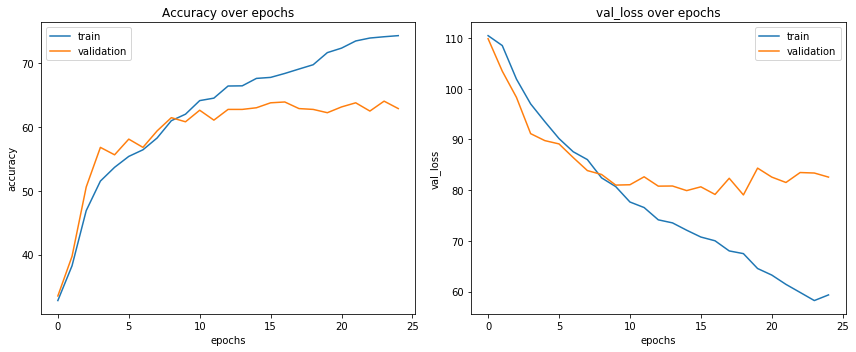

In [36]:
plot_acc_loss(history)

In [37]:
performance_nn(model, X_test, Y_test)

Classification report : 
               precision    recall  f1-score   support

           0       0.67      0.72      0.70       280
           1       0.54      0.56      0.55       277
           2       0.79      0.71      0.75       302

    accuracy                           0.67       859
   macro avg       0.67      0.67      0.67       859
weighted avg       0.67      0.67      0.67       859

Confusion matrix : 
 [[203  66  11]
 [ 77 155  45]
 [ 22  65 215]]
Test accuracy : 66.71%


In [69]:
def build_GRU(optimizer):
    model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    tf.keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25),
    tf.keras.layers.GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(32, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(3, activation='softmax')
    
])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# model=KerasClassifier(build_fn=build_GRU)

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 50)           100000    
_________________________________________________________________
gru (GRU)                    (None, 300, 128)          68736     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 207,971
Trainable params: 107,971
Non-trainable params: 100,000
_________________________________________________________________


In [71]:
model = build_GRU(optimizer='adam')

# Fitting to the training set
history = model.fit(X_train, Y_train_oh, batch_size = 256, epochs=50, validation_split=0.1, verbose=1, callbacks = [learning_rate_reduction])

Train on 6954 samples, validate on 773 samples
Epoch 1/50
6954/6954 [==============================] - 189s 27ms/sample - loss: 1.0671 - acc: 0.4162 - val_loss: 1.0094 - val_acc: 0.4787
Epoch 2/50
6954/6954 [==============================] - 176s 25ms/sample - loss: 1.0054 - acc: 0.4856 - val_loss: 0.9650 - val_acc: 0.5304
Epoch 3/50
6954/6954 [==============================] - 164s 24ms/sample - loss: 0.9855 - acc: 0.5063 - val_loss: 0.9852 - val_acc: 0.5058
Epoch 4/50
6954/6954 [==============================] - 159s 23ms/sample - loss: 0.9673 - acc: 0.5161 - val_loss: 0.9340 - val_acc: 0.5459
Epoch 5/50
6954/6954 [==============================] - 169s 24ms/sample - loss: 0.9475 - acc: 0.5383 - val_loss: 0.9267 - val_acc: 0.5395
Epoch 6/50
6954/6954 [==============================] - 158s 23ms/sample - loss: 0.9270 - acc: 0.5446 - val_loss: 0.9040 - val_acc: 0.5692
Epoch 7/50
6954/6954 [==============================] - 158s 23ms/sample - loss: 0.9099 - acc: 0.5614 - val_loss: 0.885

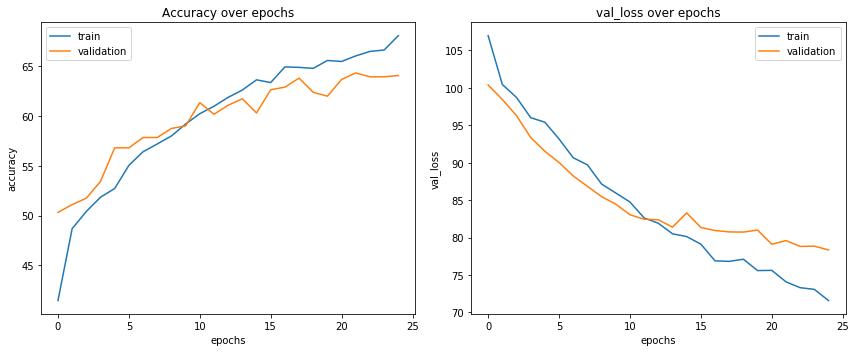

In [68]:
plot_acc_loss(history)

In [62]:
performance_nn(model, X_test, Y_test)

Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.76      0.70       280
           1       0.54      0.55      0.54       277
           2       0.81      0.67      0.73       302

    accuracy                           0.66       859
   macro avg       0.67      0.66      0.66       859
weighted avg       0.67      0.66      0.66       859

Confusion matrix : 
 [[214  57   9]
 [ 87 151  39]
 [ 28  73 201]]
Test accuracy : 65.89%


In [41]:
# Summary

# One-Hot & SVM (Baseline): 62.51%
# One-Hot & MultinomialNB: 70.9%
# Bag of Words & MultinomialNB: 70.08%
# TF-IDF & MultinomialNB: 71.25%
# TF-IDF & Artificial Neural Network: 68.8%
# GloVe Embedding & LSTM: 66.71%
# GloVe Embedding & GRU: %